<p style="text-align: center; font-size: 32px; font-weight: bold;">Classifiez automatiquement des biens de consommation</p>


## Preamble

Ce projet vise à améliorer l'expérience des utilisateurs sur la plateforme e-commerce de l'entreprise "Place de Marché". Actuellement, l'attribution manuelle des catégories aux produits par les vendeurs est peu fiable. L'objectif est d'automatiser cette tâche pour faciliter la mise en ligne de nouveaux articles et la recherche de produits, en particulier dans l'optique d'une expansion future.

La première étape de ce projet a consisté à évaluer la faisabilité d'un moteur de classification automatique des articles en différentes catégories. Les étapes suivantes ont été entreprises :

__Prétraitement des données :__ Les descriptions textuelles et les images des produits ont été prétraitées de manière appropriée.

__Extraction de caractéristiques textuelles :__ Différentes approches, telles que le "bag-of-words", le TF-IDF, Word2Vec, BERT et USE, ont été utilisées pour extraire des caractéristiques significatives des descriptions textuelles.

__Extraction de caractéristiques d'images :__ Des techniques comme SIFT, ORB, SURF et le transfert d'apprentissage avec les réseaux de neurones convolutifs (CNN) ont été employées pour extraire des caractéristiques des images.

__Réduction de dimension et visualisation :__ Les caractéristiques ont été réduites en deux dimensions et les produits ont été projetés sur un graphique coloré selon leurs catégories réelles.

__Analyse visuelle :__ Le graphique a été analysé visuellement pour évaluer la possibilité de regrouper automatiquement des produits similaires.

__Validation quantitative :__ Pour confirmer les conclusions visuelles, une mesure de similarité entre les catégories réelles et celles issues d'une segmentation en clusters a été calculée.

La première itération a montré que la regroupement automatique des produits de même catégorie est faisable, ce qui est un pas important vers l'automatisation de l'attribution des catégories.

La deuxième étape consistera à mettre en œuvre une classification supervisée basée sur les images. Cette fois-ci, nous utiliserons des techniques de "data augmentation" pour améliorer les performances du modèle.

![alt text](placedemarche.png)

<a id='sec:introduction'></a>
## I. Introduction

__Notebook d'Analyse Textuelle :__ Ce notebook contiendra les fonctions de prétraitement des données textuelles ainsi que les différentes étapes d'extraction de caractéristiques à partir des descriptions des produits. L'objectif est de préparer les données textuelles pour une analyse ultérieure. De plus, seront inclus dans ce notebook les résultats de l'étude de faisabilité qui a été menée. Les graphiques en deux dimensions, qui projettent les produits en fonction de leurs catégories réelles, ainsi que les mesures de similarité obtenues seront également présentés ici.

__Notebook de Classification Supervisée des Images (Prochainement) :__ Un autre notebook sera dédié à la classification supervisée basée sur les images. Dans ce notebook, l'objectif est d'explorer la mise en œuvre du modèle de classification supervisée en utilisant les images des produits. Les techniques de "data augmentation" qui ont été explorées pour améliorer les performances du modèle seront également mises en œuvre ici. Les performances du modèle de classification ainsi que les résultats obtenus seront présentés et discutés dans ce notebook.



In [1]:
# pour editer le jeu de donne
import pandas as pd
import numpy as np
import datetime as dt
import time
from IPython.display import Image
# pour visualiser 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import cufflinks as cf 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import importlib.metadata
from scipy import stats

# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()
%matplotlib inline

In [2]:
#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

In [3]:
!python --version

# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

print("matplotlib - ", importlib.metadata.version('matplotlib'))

Python 3.8.3
pandas - 2.0.3
numpy - 1.23.5
seaborn - 0.12.2
missingno - 0.4.2
cufflinks - 0.17.3
matplotlib -  3.6.2


### Table des Matières
- [I. Introduction](#sec:introduction)
- [II. Prétraitement du Texte](#sec:pretraitement-texte)
    - [A. Tokenization](#subsec:tokenization)
    - [B. Stemming](#subsec:stemming)
    - [C. Lemmatisation](#subsec:lemmatisation)
- [III. Modèles Bag of Words](#sec:modeles-bag-of-words)
    - [A. CountVectorizer et Tf-idf](#subsec:countvectorizer-tfidf)
- [IV. Word2Vec](#sec:word2vec)
- [V. BERT](#sec:bert)
- [VI. Universal Sentence Encoder](#sec:universal-sentence-encoder)
- [VII. Conclusion](#sec:conclusion)

<a id='sec:pretraitement-texte'></a>
## II. Prétraitement du Texte

In [4]:
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [6]:
display(df.head(5))

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                                                                                                       product_url  \
0       http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z   
1                                       http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   
2                              http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y   
3  http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt9uaqahahuf?pid=BDSEJT9UQWHDUBH4   
4            http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v?pid=BDSEJTHNGWVGWWQU   

                                                      product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

                                                                                                                       product_category_tree  \
0                           ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]   
2   ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]   
3    ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]   
4             ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   
1  BTWEGFZHGBXPHZUH         600.0             449.0   
2  BTWEG6SHXTDB2A2Y           NaN               NaN   
3  BDSEJT9UQWHDUBH4        2699.0            1299.0   
4  BDSEJTHNGWVGWWQU        2599.0             698.0   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False   
3  d4684dcdc759dd9cdf41504698d737d8.jpg                    False   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg                    False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [7]:
df.describe()


retail_price  discounted_price
count    1049.000000       1049.000000
mean     2186.197331       1584.527169
std      7639.229411       7475.099680
min        35.000000         35.000000
25%       555.000000        340.000000
50%       999.000000        600.000000
75%      1999.000000       1199.000000
max    201000.000000     201000.000000

In [8]:
df.iloc[90]

uniq_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         6ae332e2bafd23267caedfcc4453257c
crawl_timestamp                                                                                                                                                                                                                                                                                                                                                                                        

Ce jeu de données contient des informations sur des produits disponibles sur une plateforme d'e-commerce. Chaque ligne du jeu de données représente un produit individuel, et les colonnes fournissent diverses caractéristiques de ces produits. Ces caractéristiques incluent l'identifiant unique du produit, son URL, son nom, sa catégorie, son prix de détail, son prix réduit, une image associée, une description du produit, sa note et sa marque. Le jeu de données contient également des spécifications détaillées du produit, telles que le type, la taille et d'autres informations pertinentes.

In [9]:
df['product_category_tree'].head(6)

0                             ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]
3      ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]
4               ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]
5                                                                                  ["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]
Name: product_category_tree, dtype: object

La colonne "product_category_tree" contient une structure hiérarchique décrivant les catégories de produits. Elle commence par une catégorie générale et se détaille ensuite en sous-catégories plus spécifiques, fournissant ainsi un aperçu de la classification des produits. Cette structure permet de mieux comprendre le contexte global et les liens entre les différents types de produits. Cela s'avère utile pour organiser et catégoriser les produits, ce qui facilite la navigation et l'exploration de la diversité des articles disponibles sur la plateforme

In [10]:
# Fonction pour extraire les noms de catégories
def extraire_categories(ligne):
    categories = eval(ligne['product_category_tree'])
    return [categorie.strip() for categorie in categories[0].split('>>')]

# Appliquer la fonction au DataFrame
df['categories'] = df.apply(extraire_categories, axis=1)

# Créer des colonnes distinctes pour chaque catégorie
max_categories = max(df['categories'].apply(len))
for i in range(max_categories):
    df[f'Cat_{i+1}'] = df['categories'].apply(lambda x: x[i] if len(x) > i else None)

# Supprimer la colonne originale 'categories'
df.drop('categories', axis=1, inplace=True)

La colonne "product_category_tree" contient des noms de catégories organisées hiérarchiquement pour chaque produit. Le code divise ces noms de catégories en utilisant le séparateur ">>" et crée une liste de catégories pour chaque produit. Ensuite, le code crée plusieurs nouvelles colonnes, notamment "Cat_1", "Cat_2", et ainsi de suite jusqu'à "Cat_7". Chaque colonne contient le nom de catégorie correspondant à cet ordre spécifique. Ainsi, nous pouvons identifier la catégorie principale dans "Cat_1", la sous-section dans "Cat_2", et ainsi de suite, fournissant une structure plus organisée pour l'analyse ultérieure de nos données.

<AxesSubplot: >

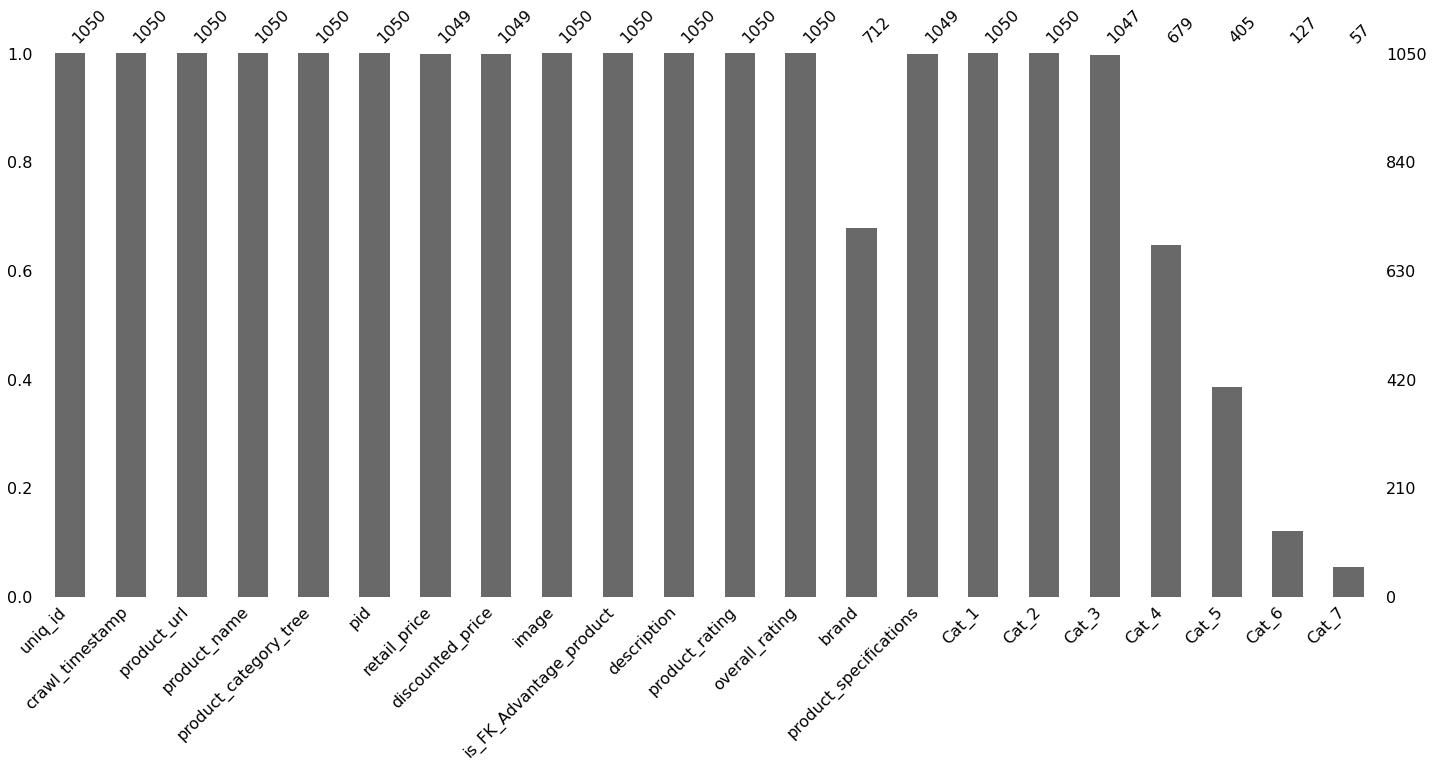

In [11]:
msno.bar(df)


À partir du diagramme à barres de msno, il est évident qu'il existe des données manquantes à partir de la colonne "cat_4" et descend jusqu'à "cat_7". Les colonnes de données "cat_1" et "cat_2" contiennent des valeurs non nulles, mais il y a 3 données manquantes dans "cat_3". Pour cette raison, nous pouvons principalement nous concentrer sur les colonnes "cat_1" et "cat_2" pour classer les produits.

In [12]:
df.groupby('Cat_1').count()['uniq_id'].sort_values(ascending=False)


Cat_1
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: uniq_id, dtype: int64

In [13]:
df.groupby('Cat_2').count()['uniq_id'].sort_values(ascending=False)

Cat_2
Wrist Watches                      149
Laptop Accessories                  87
Infant Wear                         84
Coffee Mugs                         74
Showpieces                          71
Bed Linen                           65
Fragrances                          65
Network Components                  49
Cookware                            27
Table Decor & Handicrafts           27
Combos and Kits                     24
Wall Decor & Clocks                 22
Bath Linen                          21
Curtains & Accessories              19
Makeup                              18
Baby & Kids Gifts                   15
Body and Skin Care                  15
Baby Bedding                        15
Baby Bath & Skin                    14
Decorative Lighting & Lamps         14
Kitchen Tools                       14
Kitchen & Dining Linen              14
Containers & Bottles                13
Cushions, Pillows & Covers          13
Hair Care                            9
Feeding & Nursing  

Les sous-catégories de "cat_2" apportent plus de détails spécifiques à chaque catégorie générale. Elles aident à affiner la classification des produits. Voici une interprétation des sous-catégories les plus fréquentes :

In [14]:
# Grouping cat_2 categories under cat_1 groups
cat_2_grouped = df.groupby(['Cat_1', 'Cat_2'])['uniq_id'].count().reset_index()

# Displaying the grouped categories
print(cat_2_grouped)


                         Cat_1                            Cat_2  uniq_id
0                    Baby Care                Baby & Kids Gifts       15
1                    Baby Care                 Baby Bath & Skin       14
2                    Baby Care                     Baby Bedding       15
3                    Baby Care                    Baby Grooming        4
4                    Baby Care       Diapering & Potty Training        7
5                    Baby Care                Feeding & Nursing        8
6                    Baby Care          Furniture & Furnishings        2
7                    Baby Care                      Infant Wear       84
8                    Baby Care        Strollers & Activity Gear        1
9     Beauty and Personal Care                     Bath and Spa        7
10    Beauty and Personal Care               Beauty Accessories        1
11    Beauty and Personal Care               Body and Skin Care       15
12    Beauty and Personal Care                  Com


Ce tableau présente les catégories de produits en fonction de leur classification dans "cat_1" et "cat_2". En observant les données, il est clair que certaines catégories, telles que "Baby Care" et "Beauty and Personal Care", ainsi que "Home Decor & Festive Needs" et "Home Furnishing", sont étroitement liées. Cela suggère que la classification basée uniquement sur le modèle de langue pourrait être complexe en raison de la similarité entre ces catégories.

In [15]:
# Grouping cat_2 categories under cat_2 groups
cat_3_grouped = df.groupby(['Cat_2', 'Cat_3'])['uniq_id'].count().reset_index()

# Displaying the grouped categories
print(cat_3_grouped)

                           Cat_2  \
0              Baby & Kids Gifts   
1              Baby & Kids Gifts   
2              Baby & Kids Gifts   
3               Baby Bath & Skin   
4               Baby Bath & Skin   
5               Baby Bath & Skin   
6                   Baby Bedding   
7                   Baby Bedding   
8                   Baby Bedding   
9                   Baby Bedding   
10                  Baby Bedding   
11                 Baby Grooming   
12                 Baby Grooming   
13                 Baby Grooming   
14                 Baby Grooming   
15               Bar & Glassware   
16               Bar & Glassware   
17                    Bath Linen   
18                    Bath Linen   
19                  Bath and Spa   
20                  Bath and Spa   
21                  Bath and Spa   
22            Beauty Accessories   
23                     Bed Linen   
24                     Bed Linen   
25                     Bed Linen   
26            Body and Skin 

In [16]:
# # creation of a corpus of all the descriptions
# corpus = ' '.join(df['description'].values)
# print("total nb of words in the whole corpus: ", len(corpus.split()))

<a id='subsec:tokenization'></a>
## A. Tokenization

In [17]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ismailcanoguz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ismailcanoguz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ismailcanoguz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
# Tokenisation
def tokenizer_fct(phrase):
    phrase_propre = phrase.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    mots_tokens = word_tokenize(phrase_propre)
    return mots_tokens

La tokenisation est le processus de découpage d'un texte en mots individuels ou en jetons. Dans cette fonction, la phrase d'entrée est nettoyée en remplaçant les caractères spéciaux tels que '-', '+', '/', et '#' par des espaces. Ensuite, la fonction word_tokenize de NLTK est utilisée pour diviser la phrase nettoyée en une liste de mots ou de jetons.

In [19]:
from nltk.corpus import stopwords

# Filtre des mots vides et des mots composés uniquement de chiffres
stop_mots = set(stopwords.words('english')) | {'[', ']', ',', '.', ':', '?', '(', ')'}

def filtre_mots_vides_fct(liste_mots):
    mots_filtres = [mot for mot in liste_mots if not mot in stop_mots and not mot.isdigit()]
    mots_filtres2 = [mot for mot in mots_filtres if len(mot) > 2]
    return mots_filtres2

 Les mots vides sont des mots courants comme "and," "the," "is," etc., qui sont souvent supprimés lors de l'analyse de texte car ils n'apportent pas de signification significative. Dans cette fonction, une liste de mots vides anglais est chargée à partir du corpus de NLTK. La fonction filtre_mots_vides_fct filtre ces mots vides de la liste de mots obtenue à partir de la tokenisation. De plus, les mots dont la longueur est inférieure ou égale à 2 sont supprimés.

In [20]:
# Transformation en Lettres Minuscules
def en_minuscules(liste_mots):
    mots_transformes = [mot.lower() for mot in liste_mots]
    return mots_transformes

# Transformation en Lettres Majuscules
def en_majuscules(liste_mots):
    mots_transformes = [mot.upper() for mot in liste_mots]
    return mots_transformes

Ces deux fonctions visent à transformer les mots du texte en lettres minuscules ou majuscules respectivement. Cela permet de normaliser les mots tout en conservant l'information essentielle du texte. Ces transformations peuvent être utilisées selon les besoins de l'analyse, par exemple, pour standardiser les données texte avant d'appliquer des méthodes de traitement du langage naturel.

<a id='subsec:stemming'></a>
## B. Stemming

In [21]:
from nltk.stem import PorterStemmer

# Stemmatisation (réduction aux racines)
def stemmatisation_fct(liste_mots):
    stemmer = PorterStemmer()
    mots_stem = [stemmer.stem(mot) for mot in liste_mots]
    return mots_stem

__Stemming__ : Le stemming est un processus plus simple et plus agressif. Il coupe les préfixes et les suffixes des mots pour trouver leur forme racine. La forme racine résultante n'est pas toujours un mot valide. Par exemple, "running" pourrait être réduit à "run," ce qui est un mot valide, mais "flies" pourrait être réduit à "fli," ce qui n'est pas un mot valide.

<a id='subsec:lemmatisation'></a>
## C. Lemmatisation

In [22]:
from nltk.stem import WordNetLemmatizer
# Lemmatisation (base des mots)
def lemmatisation_fct(liste_mots):
    lemmatiseur = WordNetLemmatizer()
    mots_lem = [lemmatiseur.lemmatize(mot) for mot in liste_mots]
    return mots_lem

__Lemmatisation__ : La lemmatisation est une approche plus linguistiquement informée. Elle réduit les mots à leur forme de base ou forme de dictionnaire (appelée lemme). Le lemme est toujours un mot valide. Par exemple, "better" pourrait être lemmatisé en "good," et "running" pourrait être lemmatisé en "run."

Bien qu'ils servent à des fins quelque peu similaires, la lemmatisation est souvent préférée dans les tâches de traitement du langage naturel où il est important de maintenir la validité des mots. NLTK, en tant que bibliothèque complète pour le traitement du langage naturel, inclut à la fois des fonctions de stemming et de lemmatisation pour offrir de la flexibilité et des options pour différents cas d'utilisation

La lemmatisation est le processus de réduction des mots à leur forme de base ou forme lexicale (lemme). Cette fonction utilise le WordNetLemmatizer de NLTK pour lemmatiser chaque mot dans la liste de mots obtenue après les étapes de traitement précédentes. Cette étape aide à regrouper des mots similaires et à réduire la dimensionnalité des données.

In [23]:
# Fonction pour la préparation du texte pour le modèle Bag of Words (CountVectorizer et Tf-idf, Word2Vec)
def transformer_bow_fct(texte_desc):
    mots_tokens = tokenizer_fct(texte_desc)
    mots_filtres = filtre_mots_vides_fct(mots_tokens)
    mots_minuscules = en_minuscules(mots_filtres)
    texte_transforme = ' '.join(mots_minuscules)
    return texte_transforme

Cette fonction prend une description de texte en entrée et applique la tokenisation, le filtrage des mots vides et la mise en minuscules pour préparer le texte pour les modèles Bag of Words tels que CountVectorizer et Tf-idf. La liste résultante de mots prétraités est jointe en une seule chaîne, qui est le format attendu par ces modèles.

In [24]:
# Fonction pour la préparation du texte pour le modèle Bag of Words avec lemmatisation
def transformer_bow_lem_fct(texte_desc):
    mots_tokens = tokenizer_fct(texte_desc)
    mots_filtres = filtre_mots_vides_fct(mots_tokens)
    mots_minuscules = en_minuscules(mots_filtres)
    mots_lem = lemmatisation_fct(mots_minuscules)
    texte_transforme = ' '.join(mots_lem)
    return texte_transforme

Similaire à la fonction précédente, cette fonction applique également la lemmatisation au texte après les étapes de tokenisation, de filtrage des mots vides et de mise en minuscules. Ce texte prétraité convient aux modèles Bag of Words avec lemmatisation.

In [25]:
# Fonction pour la préparation du texte pour le modèle Bag of Words avec la stemmatisation
def transformer_bow_stem_fct(texte_desc):
    mots_tokens = tokenizer_fct(texte_desc)
    mots_filtres = filtre_mots_vides_fct(mots_tokens)
    mots_minuscules = en_minuscules(mots_filtres)
    mots_stem = stemmatisation_fct(mots_minuscules)
    texte_transforme = ' '.join(mots_stem)
    return texte_transforme

À l'instar de la fonction précédente, cette fonction effectue les étapes de tokenisation, de filtrage des mots vides et de mise en minuscules sur le texte. Cependant, au lieu de la lemmatisation, elle utilise la stemmatisation pour réduire les mots à leur forme racine. Ce texte prétraité est adapté pour les modèles Bag of Words avec utilisation de la stemmatisation.

In [26]:
# Fonction pour la préparation du texte pour les modèles d'apprentissage profond (USE et BERT)
def transformer_dl_fct(texte_desc):
    mots_tokens = tokenizer_fct(texte_desc)
    mots_minuscules = en_minuscules(mots_tokens)
    texte_transforme = ' '.join(mots_minuscules)
    return texte_transforme

Cette fonction prépare le texte pour les modèles d'apprentissage profond tels que Universal Sentence Encoder (USE) et BERT. Elle effectue la tokenisation et la mise en minuscules, tout comme les autres fonctions. Cependant, la lemmatisation n'est pas appliquée car ces modèles gèrent des représentations de mots contextualisées et n'exigent pas de prétraitement basé sur les lemmes.

<a id='sec:modeles-bag-of-words'></a>
# III. Modèles Bag of Words


Dans cette section, nous allons explorer les modèles Bag of Words, une approche classique en traitement de texte pour représenter des données textuelles de manière numérique. Nous commencerons par appliquer deux techniques courantes, le CountVectorizer et le Tf-idf (Term Frequency-Inverse Document Frequency), à notre colonne 'description' pour convertir le texte en vecteurs de caractéristiques numériques en utilisant la lemmatisation, une technique de base des mots, pour obtenir une représentation plus précise. En parallèle, nous explorerons également d'autres méthodes d'apprentissage profond, notamment l'Universal Sentence Encoder (USE) et BERT, dans les sections dédiées, pour comparer les performances de ces différentes techniques d'extraction de caractéristiques textuelles.

Le code suivant illustre l'application de ces transformations à la colonne 'description' de notre jeu de données, créant ainsi différentes représentations numériques du texte pour une analyse ultérieure.

In [27]:
#Application des transformations à la colonne 'description'

# Application de la transformation pour le sac de mots (CountVectorizer et Tf-idf)
df['sentence_bow'] = df['description'].apply(lambda x: transformer_bow_fct(x)) 

# Application de la transformation avec lemmatisation pour le sac de mots
df['sentence_bow_lem'] = df['description'].apply(lambda x: transformer_bow_lem_fct(x)) 

# Application de la transformation pour le sac de mots avec stemmatisation
df['sentence_bow_stem'] = df['description'].apply(lambda x: transformer_bow_stem_fct(x))

# Application de la transformation pour les méthodes d'apprentissage profond (USE et BERT)
df['sentence_dl'] = df['description'].apply(lambda x: transformer_dl_fct(x)) 

In [28]:
df[['sentence_bow', 'sentence_bow_lem','sentence_bow_stem','sentence_dl']].head(5)

sentence_bow  \
0  key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack price this curtain enhances look interiors.this curtain made high quality polyester fabric.it features eyelet style stitch metal ring.it makes room environment romantic loving.this curtain ant wrinkle anti shrinkage elegant apparance.give home bright modernistic appeal designs the surreal attention sure steal hearts these contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening create special moments joyous beauty given soothing prints bring home elegant curtain softly filters light room get right amount sunlight. specifications elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed for door type eyelet model name abstract polyester door curtain set model duster25 color multicolor dimensions length box number contents sales package pack sales package curtains body design material polyester   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         specifications sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal for men women boys girls model asvtwl322 color red yellow blue size mediam dimensions length inch width inch box number contents sales package sales package bath towel   
2                                                                                                                      key features eurospa cotton terry face towel set size small height inch gsm eurospa cotton terry face towel set piece face towel set assorted price eurospa brings exclusively designed soft cotton towels export quality all products soft texture takes care skin gives enriched feeling deserve eurospa exporting bath towels lot renowned brands last years famous fine prints absorbency softness durability note our product cotton susceptible shrinkage product color may vary picture size may vary wash care wash cold water iron bleach flat dry wash first use size face towel cms cms. specifications eurospa cotton terry face towel set piece face towel set assorted bath towel features material cotton terry design shuvam general brand eurospa gsm type face towel set model name shuvam20pcftsetassorted ideal for boys girls men women model shuvam20pcftsetassorted size small color assorted dimensions weight length inch width inch box number contents sales package sales package piece face towel set   
3                                                                                                                                                                                                                                                                                                                                                                                         key features santosh royal fashion cotton printed king sized double bedsheet royal bedsheet perfact wedding gifting specifications santosh royal fashion cotton printed king sized double bedsheet bedsheet,2 pillow cover multicolor general brand santosh roy

In [29]:
df[['description','sentence_bow', 'sentence_bow_lem','sentence_bow_stem','sentence_dl']][90:91]

description  \
90  Buy Exotic India Adi Buddha Vajrasattva Showpiece  -  27.94 cm for Rs.21800 online. Exotic India Adi Buddha Vajrasattva Showpiece  -  27.94 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.   

                                                                                                                                                                                                           sentence_bow  \
90  buy exotic india adi buddha vajrasattva showpiece 27.94 rs.21800 online exotic india adi buddha vajrasattva showpiece 27.94 best prices free shipping cash delivery only genuine products day replacement guarantee   

                                                                                                                                                                                                     sentence_bow_lem  \
90  buy exotic india adi buddha vajrasattva showpiece 27.94 rs.21800 online exotic india adi buddha vajrasattva showpiece 27.94 best price free shipping cash delivery only genuine product day replacement guarantee   

                                                                                                                                                                                  sentence_bow_stem  \
90  buy exot india adi buddha vajrasattva showpiec 27.94 rs.21800 onlin exot india adi buddha vajrasattva showpiec 27.94 best price free ship cash deliveri onli genuin product day replac guarante   

                                                                                                                                                                                                                                              sentence_dl  
90  buy exotic india adi buddha vajrasattva showpiece 27.94 cm for rs.21800 online . exotic india adi buddha vajrasattva showpiece 27.94 cm at best prices with free shipping & cash on delivery . only genuine products . 30 day replacement guarantee .

In [30]:
# Créer un encodage de labels pour les valeurs uniques dans la colonne 'Cat_1'
encodage_labels = {label: idx for idx, label in enumerate(df['Cat_1'].unique())}

In [31]:
display(encodage_labels)

{'Home Furnishing': 0,
 'Baby Care': 1,
 'Watches': 2,
 'Home Decor & Festive Needs': 3,
 'Kitchen & Dining': 4,
 'Beauty and Personal Care': 5,
 'Computers': 6}

In [32]:
# Ajouter une nouvelle colonne 'label' avec les labels encodés
df['label'] = df['Cat_1'].map(encodage_labels)

display(df['label'].value_counts(normalize=True))

label
0    0.142857
1    0.142857
2    0.142857
3    0.142857
4    0.142857
5    0.142857
6    0.142857
Name: proportion, dtype: float64

In [33]:
encodage_labels.items()

dict_items([('Home Furnishing', 0), ('Baby Care', 1), ('Watches', 2), ('Home Decor & Festive Needs', 3), ('Kitchen & Dining', 4), ('Beauty and Personal Care', 5), ('Computers', 6)])

In [34]:
# Obtenir les labels numériques uniques et leurs noms de catégories correspondants
legend_labels = [f"{categorie} ({label})" for label, categorie in encodage_labels.items()]

# Afficher les libellés de légende
display(legend_labels)

['0 (Home Furnishing)',
 '1 (Baby Care)',
 '2 (Watches)',
 '3 (Home Decor & Festive Needs)',
 '4 (Kitchen & Dining)',
 '5 (Beauty and Personal Care)',
 '6 (Computers)']

In [35]:
from sklearn import cluster, metrics
from sklearn import manifold

# Valeurs réelles des catégories
true_labels = df['label'].values

# Nombre de catégories uniques
num_labels = len(encodage_labels) 

# Fonction pour le calcul du score ARI
def ARI_fct(features):
    # Calcul du temps de départ
    time1 = time.time()
    
    # Réduction dimensionnelle avec t-SNE
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                         init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Clustering des données réduites avec KMeans
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    # Calcul des scores ARI, silhouette, homogénéité, complétude, V-measure
    ARI = np.round(metrics.adjusted_rand_score(true_labels, cls.labels_), 2)
    
    Silhouette_score_value = np.round(metrics.silhouette_score(X_tsne, cls.labels_), 2)
    
    homogeneity = np.round(metrics.homogeneity_score(true_labels, cls.labels_), 2)
    
    completeness = np.round(metrics.completeness_score(true_labels, cls.labels_), 2)
    
    v_measure = np.round(metrics.v_measure_score(true_labels, cls.labels_), 2)

    
    # Calcul du temps écoulé
    time2 = np.round(time.time() - time1, 2)
    
    # Affichage des résultats
    print("Résultats des Métriques de Clustering:")
    print("=====================================")
    print(f"ARI Score:       {ARI}\n"
      f"Silhouette Score: {round(Silhouette_score_value,2)}\n"
      f"Homogénéité:     {homogeneity}\n"
      f"Complétude:      {completeness}\n"
      f"V-Measure:       {v_measure}\n"
      f"Temps:           {time2} secondes")


    return ARI, X_tsne, cls.labels_


# Fonction pour la visualisation t-SNE
def TSNE_visu_fct(X_tsne, true_labels, labels, ARI):
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    
    ax1 = axes[0]
    scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=true_labels, cmap='Set1')
    ax1.legend(handles=scatter1.legend_elements()[0], labels=legend_labels, loc="upper left", bbox_to_anchor=(1, 1), title="Catégorie")
    ax1.set_title('Représentation des produits par catégories réelles')

    ax2 = axes[1]
    scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax2.legend(handles=scatter2.legend_elements()[0], labels=set(labels), loc="upper left", bbox_to_anchor=(1, 1), title="Clusters")
    ax2.set_title('Représentation des produits par clusters')
    
    plt.tight_layout()  # Adjusts the layout to prevent overlapping
    plt.show()
    print("ARI:", ARI)

__Homogénéité__ mesure si les points d'une même classe réelle se trouvent dans un même cluster. 

__Complétude__ évalue si les points d'une même classe réelle sont regroupés dans un même cluster.

L'homogénéité se concentre sur la correspondance entre clusters et classes, tandis que la complétude regarde comment les classes sont bien représentées dans les clusters. Un score parfait est 1.0 pour les deux mesures.

__V-Measure__ est une mesure qui combine à la fois l'homogénéité et la complétude pour fournir une mesure globale de la qualité du clustering. Elle tient compte à la fois de la correspondance entre clusters et classes ainsi que de la distribution des classes dans les clusters. Une V-Mesure parfaite est 1.0.

<a id='subsec:countvectorizer-tfidf'></a>
## A. CountVectorizer et Tf-idf

In [36]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Importation des méthodes de vectorisation
# CountVectorizer
# Cette méthode convertit le texte en une matrice de comptage de mots.
# Les mots courants (stop words) sont exclus et les mots rares sont inclus.
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
cv_fit = cvect.fit(df['sentence_bow'])  # Ajustement du modèle aux données
cv_transform = cvect.transform(df['sentence_bow'])  # Transformation du texte en matrice de comptage

# Tf-idf (Term Frequency-Inverse Document Frequency)
# Cette méthode calcule la fréquence d'apparition d'un mot dans un document
# pondérée par son importance dans l'ensemble des documents.
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf_fit = ctf.fit(df['sentence_bow'])  # Ajustement du modèle aux données
ctf_transform = ctf.transform(df['sentence_bow'])  # Transformation du texte en matrice Tf-idf

Le __CountVectorizer__ transforme le texte en une matrice où chaque ligne représente un document et chaque colonne représente un mot unique. Les cellules de la matrice contiennent le nombre d'occurrences de chaque mot dans chaque document. Les mots courants (stop words) sont ignorés et les mots rares (apparaissant moins souvent) sont inclus. Cette représentation est simple et permet de capturer la fréquence des mots, mais ne tient pas compte de l'importance relative des mots.

Le __TfidfVectorizer__ calcule une valeur pondérée pour chaque mot dans chaque document. La fréquence de chaque mot dans un document est pondérée par son importance dans l'ensemble des documents. Les mots courants sont également ignorés, et les mots rares et importants sont mis en avant. Cette représentation tient compte de l'importance relative des mots dans le texte.

Ces méthodes de vectorisation sont couramment utilisées pour transformer du texte en une forme numérique adaptée à l'analyse de données et au machine learning. Elles sont utiles pour préparer les données textuelles en vue de l'apprentissage automatique et de la classification.

In [37]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

CountVectorizer : 
-----------------
Résultats des Métriques de Clustering:
ARI Score:       0.35
Silhouette Score: 0.4699999988079071
Homogénéité:     0.47
Complétude:      0.48
V-Measure:       0.48
Temps:           5.23 secondes

Tf-idf : 
--------
Résultats des Métriques de Clustering:
ARI Score:       0.52
Silhouette Score: 0.5
Homogénéité:     0.59
Complétude:      0.6
V-Measure:       0.59
Temps:           5.36 secondes


Les résultats montrent que la méthode Tf-idf surpasse CountVectorizer en termes de performance de clustering. Les scores améliorés d'ARI, de silhouette, d'homogénéité, de complétude et de V-Measure indiquent une meilleure capacité de la méthode Tf-idf à capturer les relations et les similitudes entre les données.

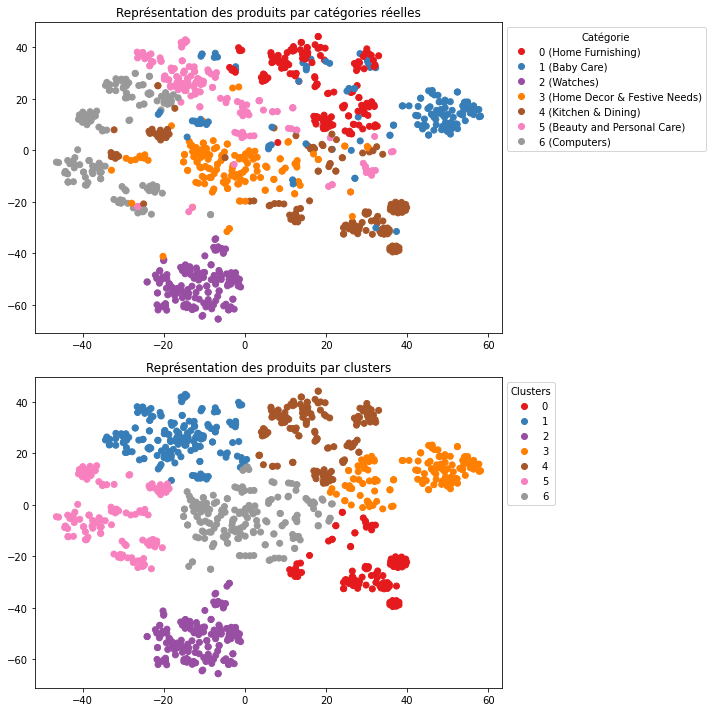

ARI: 0.52


In [38]:
TSNE_visu_fct(X_tsne, true_labels, labels, ARI)



In [39]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

# Transformation des étiquettes de cluster
cls_labels_transform = conf_mat_transform(true_labels, labels)

# Matrice de confusion après transformation
conf_mat = metrics.confusion_matrix(true_labels, cls_labels_transform)
print(conf_mat)

# Rapport de classification
print(metrics.classification_report(true_labels, cls_labels_transform))

Correspondance des clusters :  [4 5 2 1 0 6 3]
[[112  29   0   1   0   8   0]
 [ 21  95   0  11   4  19   0]
 [  0   0 150   0   0   0   0]
 [  0   5   4 124   2   4  11]
 [  0   7   0  24  91   3  25]
 [ 10   4   0  20  13 101   2]
 [  0   0   0   2   0  50  98]]
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       150
           1       0.68      0.63      0.66       150
           2       0.97      1.00      0.99       150
           3       0.68      0.83      0.75       150
           4       0.83      0.61      0.70       150
           5       0.55      0.67      0.60       150
           6       0.72      0.65      0.69       150

    accuracy                           0.73      1050
   macro avg       0.74      0.73      0.73      1050
weighted avg       0.74      0.73      0.73      1050



<AxesSubplot: >

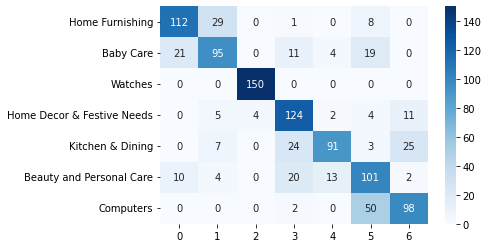

In [40]:
# Visualisation de la matrice de confusion avec un heatmap
df_cm = pd.DataFrame(conf_mat, index = [label for label in encodage_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues",fmt='d')

À partir de la visualisation t-SNE des descriptions transformées en utilisant la technique TF-IDF, des tendances intéressantes émergent. Les produits de la catégorie 'Montres' se regroupent de manière nette et distincte, indiquant une classification efficace. De manière remarquable, des parties des catégories 'Cuisine et Salle à Manger' ainsi que 'Soins pour Bébés' se regroupent également, avec des couleurs distinctes en brun et en bleu. Cependant, il est important de noter que les descriptions des produits 'Soins pour Bébés' présentent une certaine interférence avec celles de la catégorie 'Ameublement de la Maison'. Des observations similaires peuvent être faites pour la catégorie 'Informatique', qui montre une séparation bien qu'elle ne soit pas aussi marquée que dans la catégorie 'Montres'. Cette visualisation éclairante met en lumière les tendances de regroupement de différentes catégories de produits, suggérant des niveaux de distinction variables et des zones potentielles pour une analyse et une amélioration ultérieures.

In [41]:
from matplotlib.image import imread

# Sélection des indices des images du cluster "Watches"
ids_a_afficher = [i for i in range(len(df["description"])) \
                if (df.iloc[i]['Cat_1']!='Watches') and (labels[i]==2)]


len(ids_a_afficher)

4

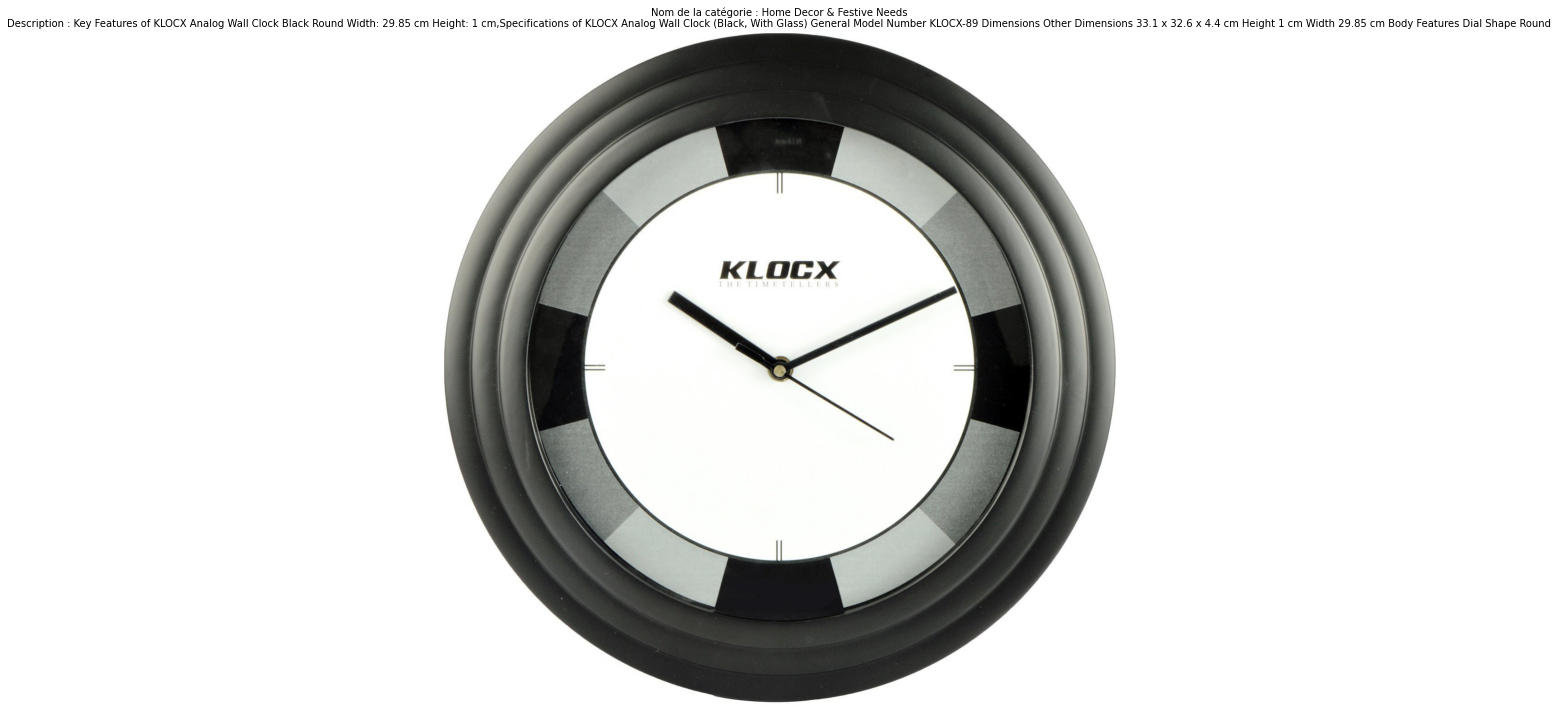

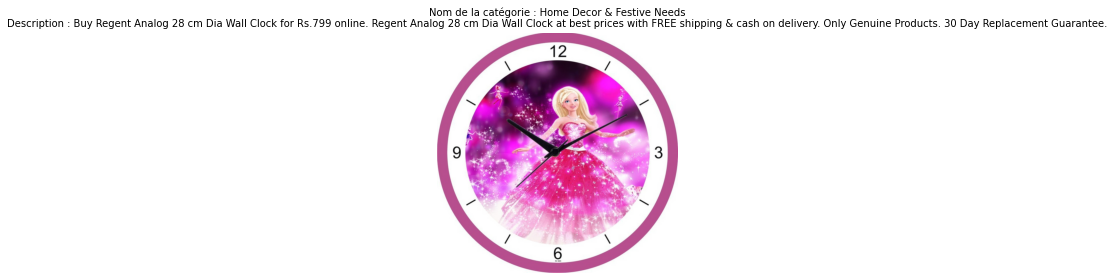

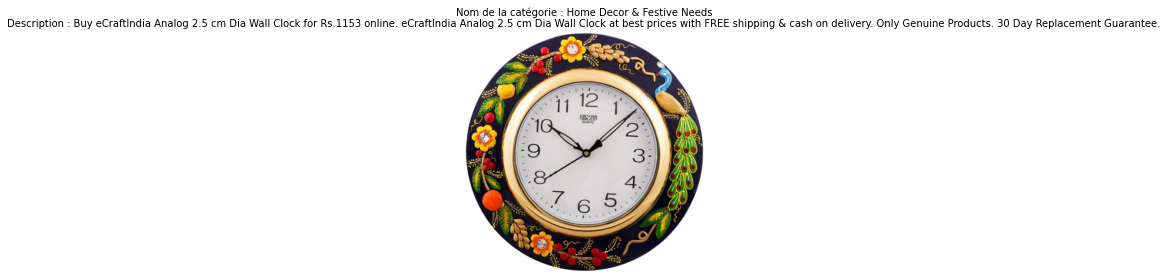

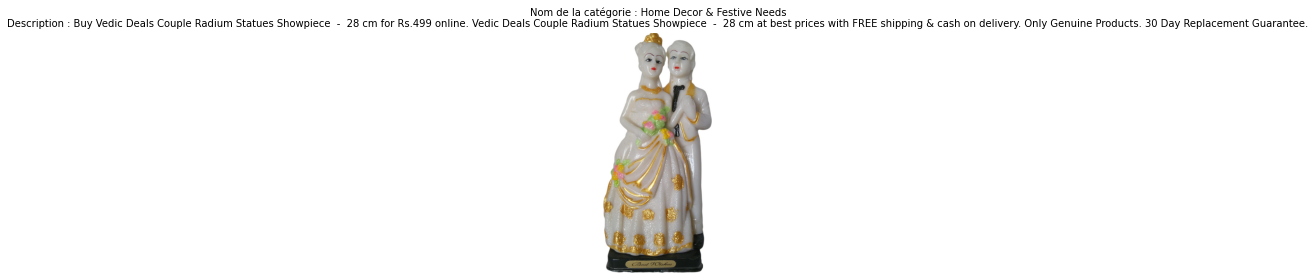

In [42]:
# Définissez le chemin de votre répertoire d'images
path = 'Flipkart/Images'  # Mettez à jour avec le chemin correct vers votre répertoire d'images


# Créez une grille de sous-graphiques 4x1
plt.figure(figsize=(10, 10))  # Augmentez la taille de la figure

for i, row_id in enumerate(ids_a_afficher):
#     plt.subplot(4, 1, i + 1)
    filename = path + '/' + df['image'][row_id]  # Obtenez le nom de fichier de l'image depuis la colonne 'image'
    image = imread(filename)
    plt.imshow(image)
    plt.axis('off')
    
    # Augmentez la taille et la police du titre
    cat_1 = df['Cat_1'][row_id]
    description = df['description'][row_id]
    plt.title(f'Nom de la catégorie : {cat_1}\nDescription : {description}', fontsize=10)  # Ajustez la taille de la police selon vos préférences

    plt.tight_layout()
    plt.show()

[122, 310, 312, 318, 321, 323, 324, 326, 327, 329, 330, 332, 333, 335, 336, 339, 341, 343, 345, 348, 349, 350, 351, 352, 353, 354, 355, 364, 367, 369, 371, 373, 379, 380, 383, 390, 391, 394, 397, 398, 399, 400, 403, 407, 410, 413, 419, 420, 421, 458, 604, 605]


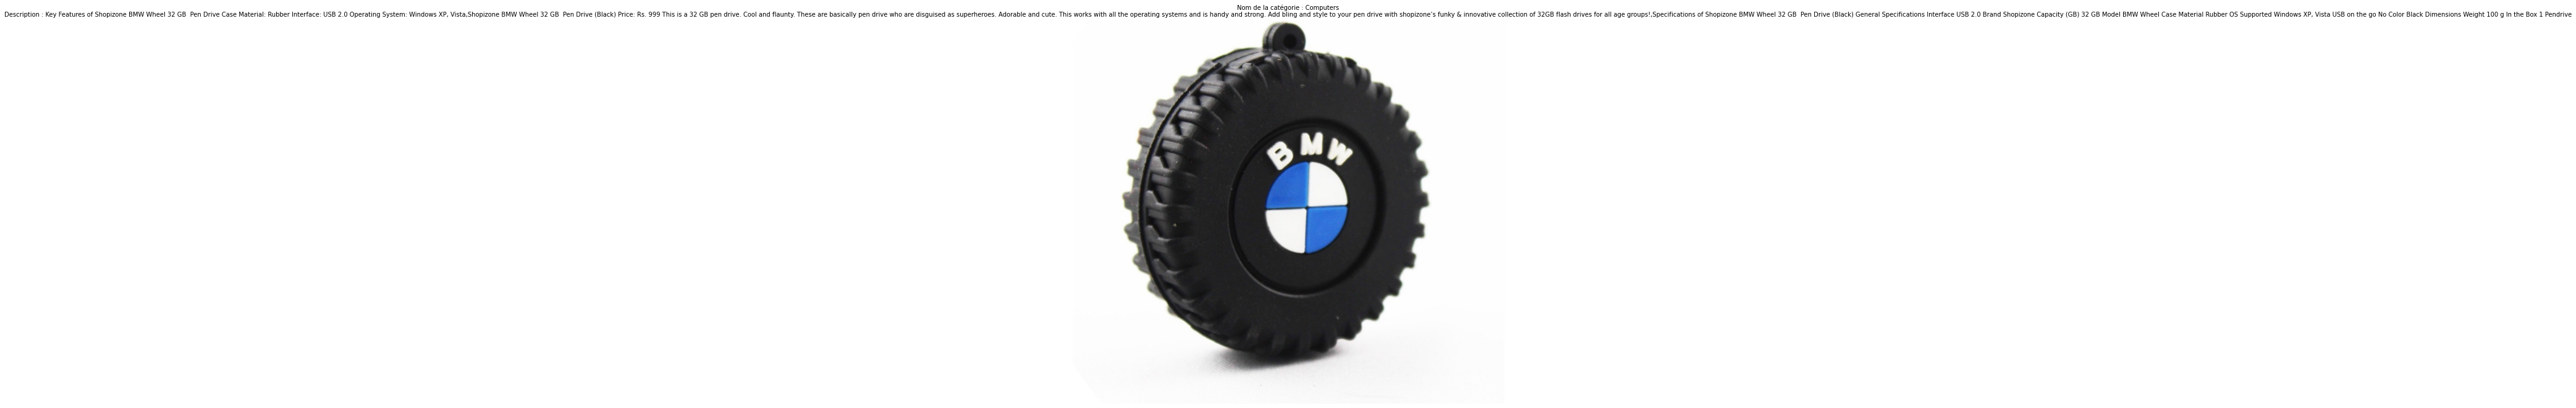

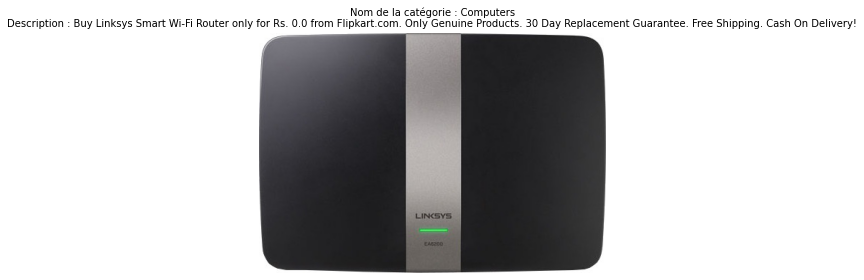

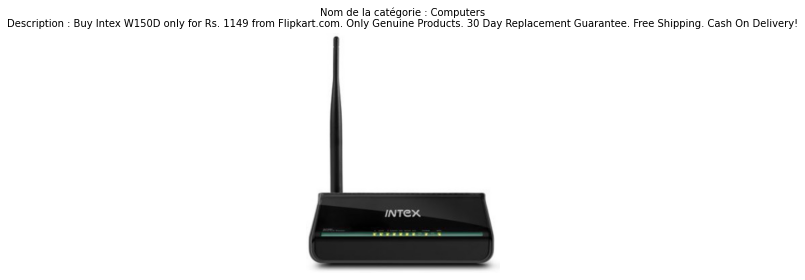

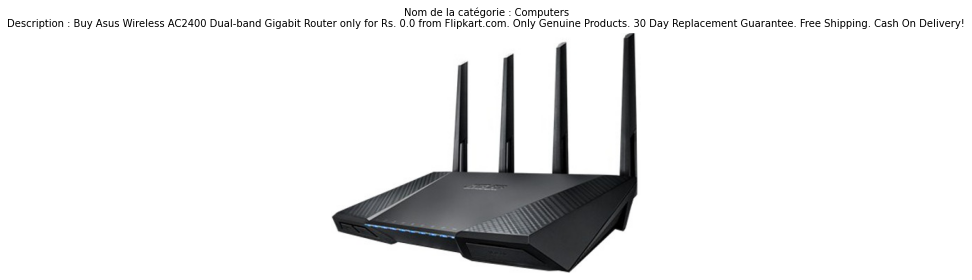

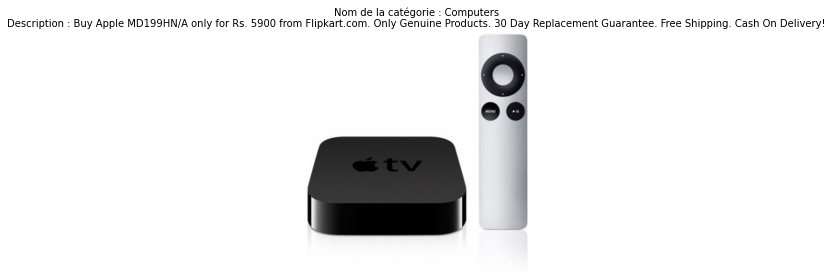

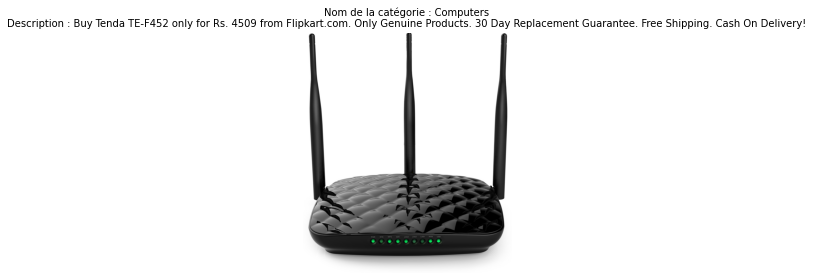

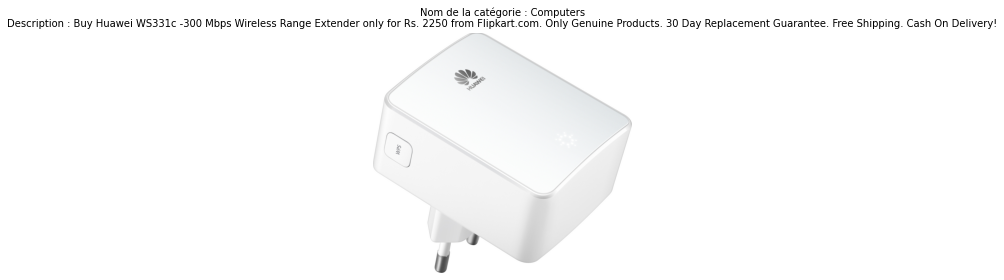

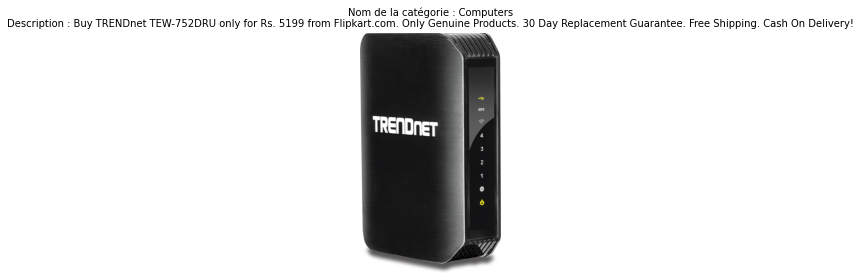

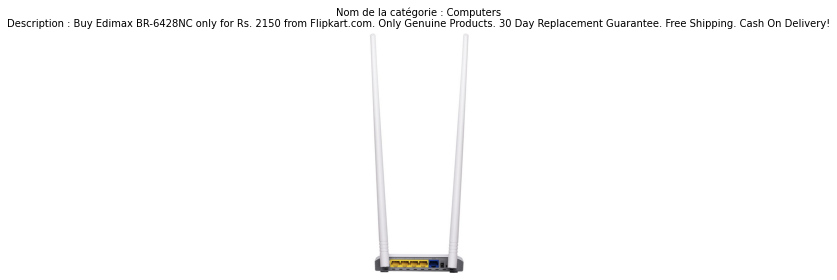

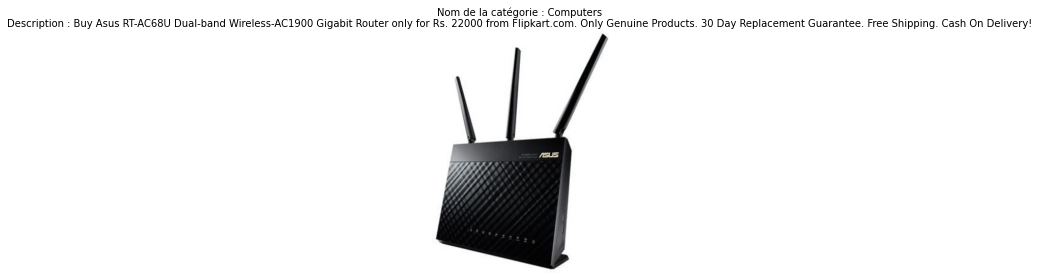

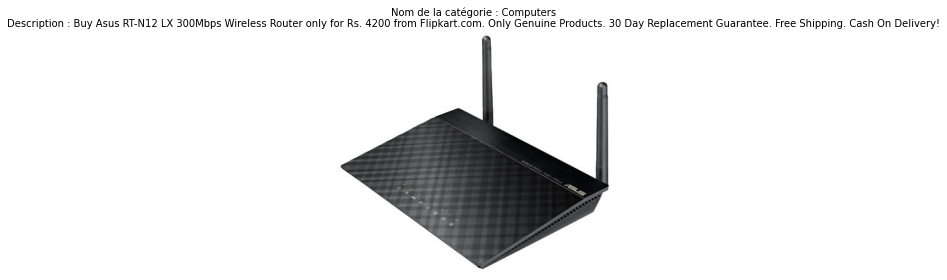

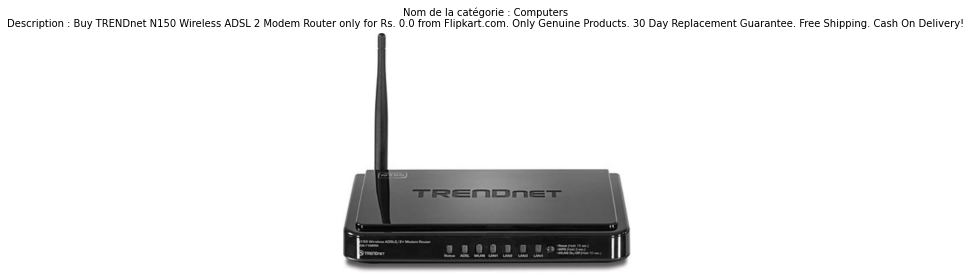

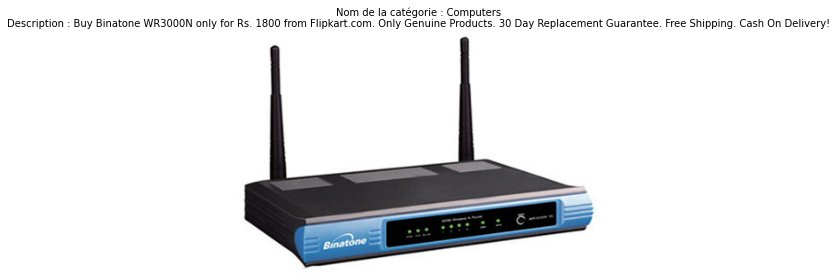

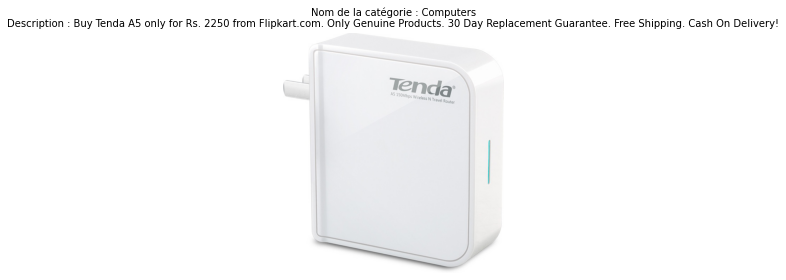

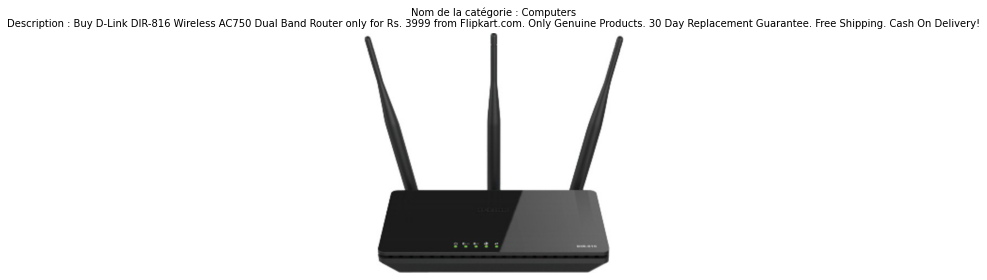

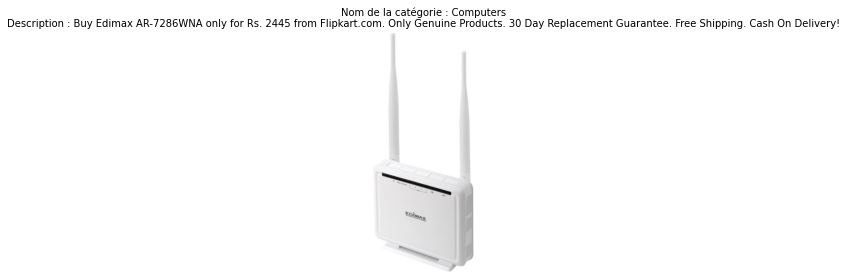

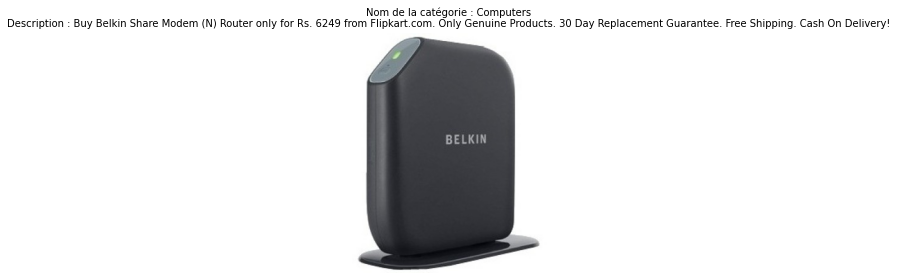

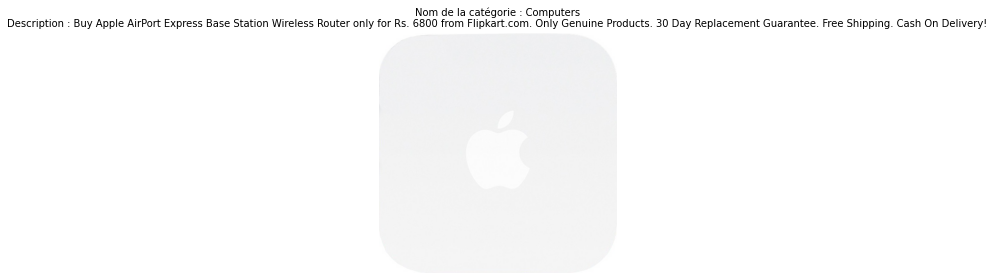

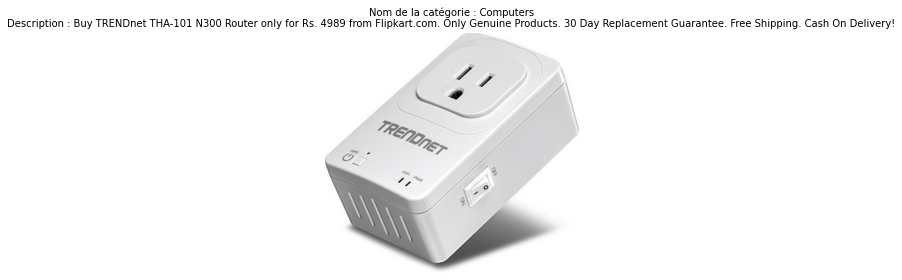

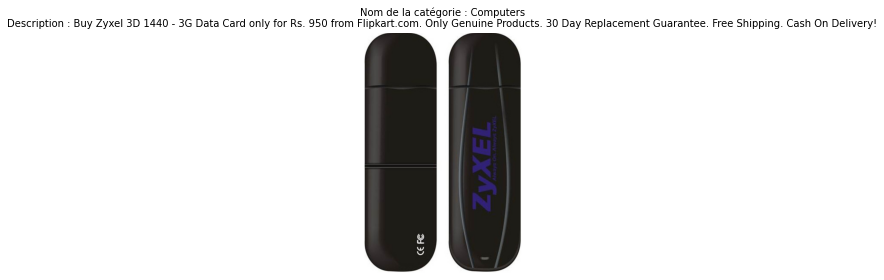

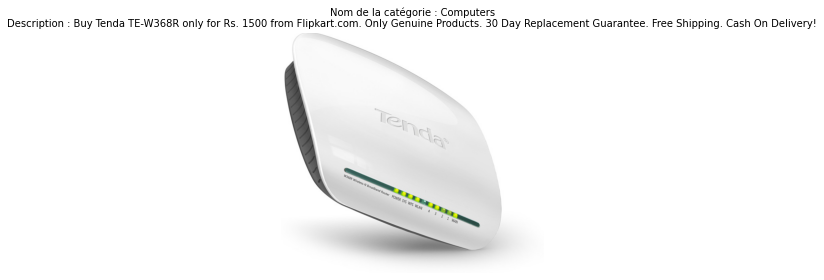

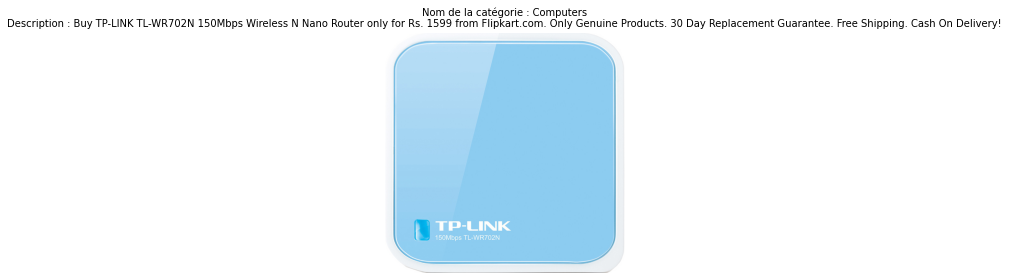

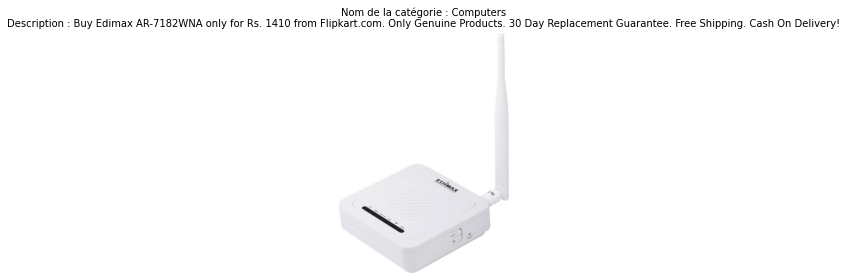

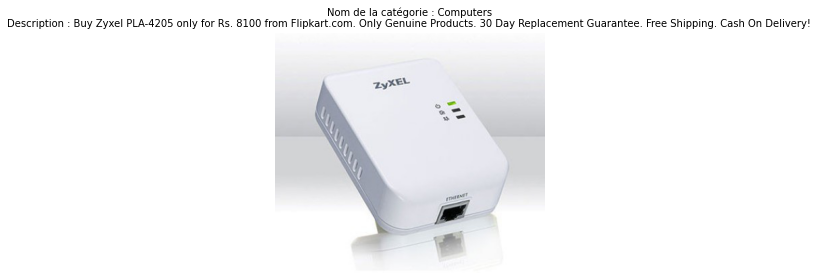

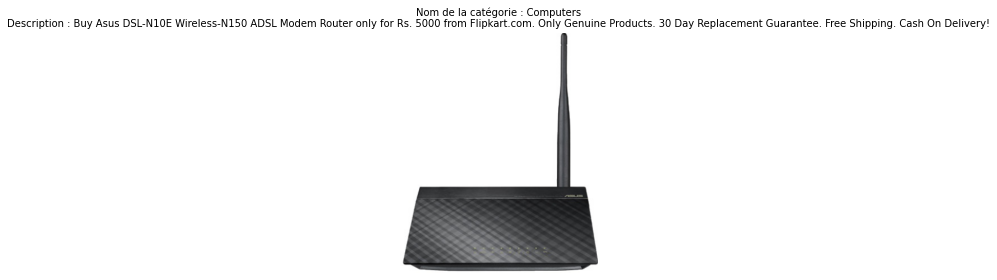

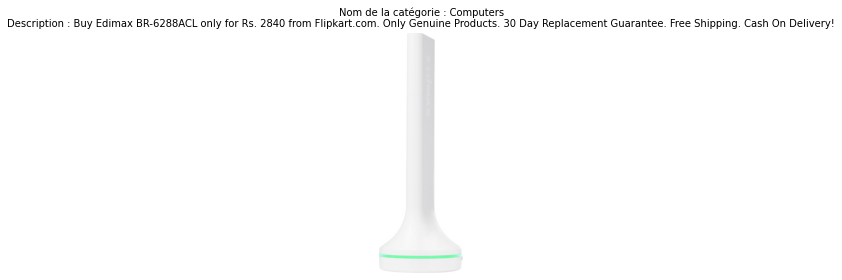

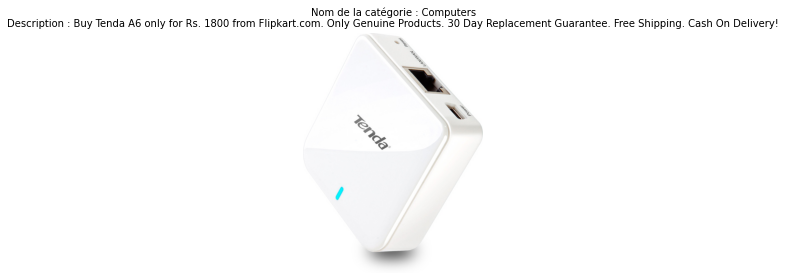

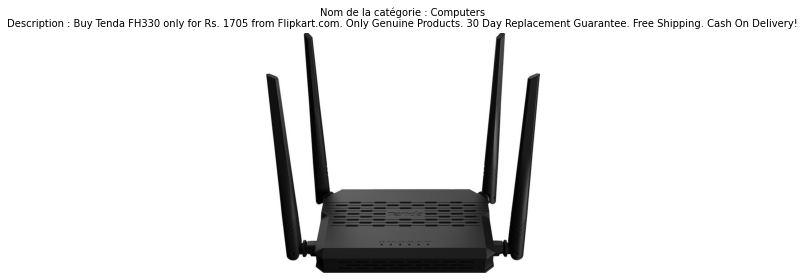

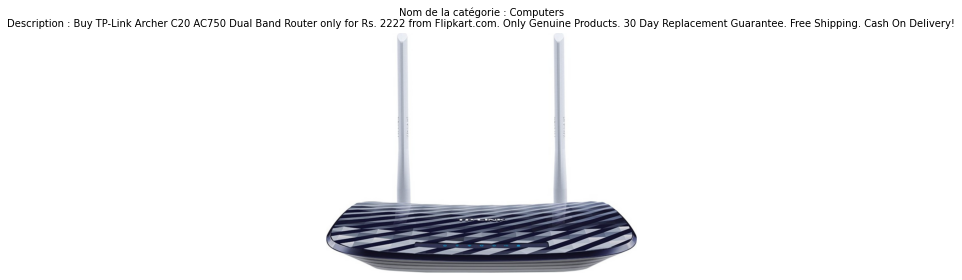

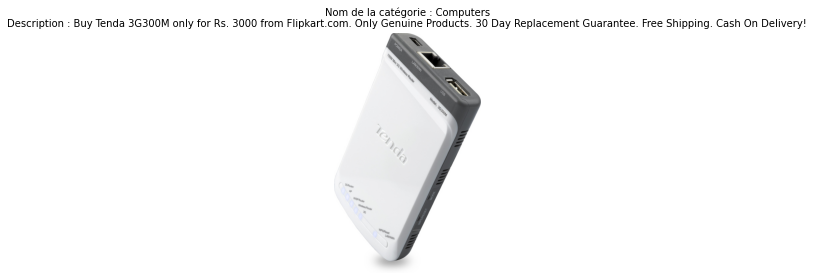

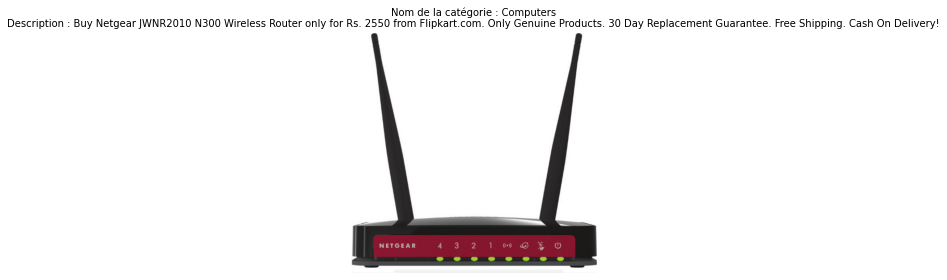

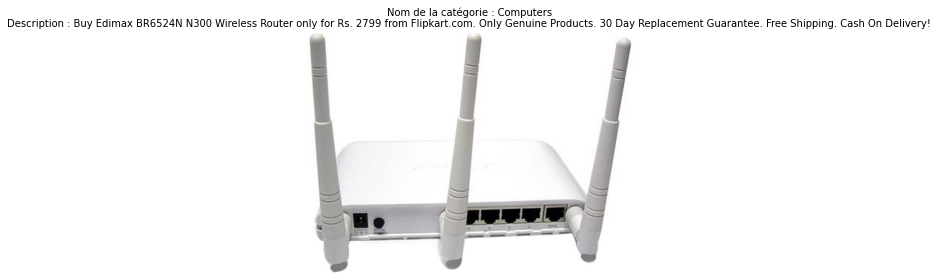

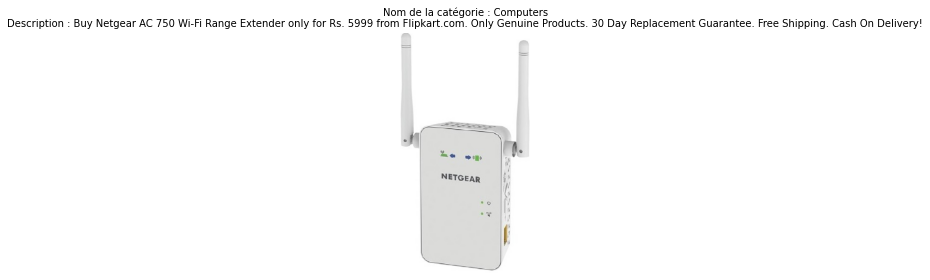

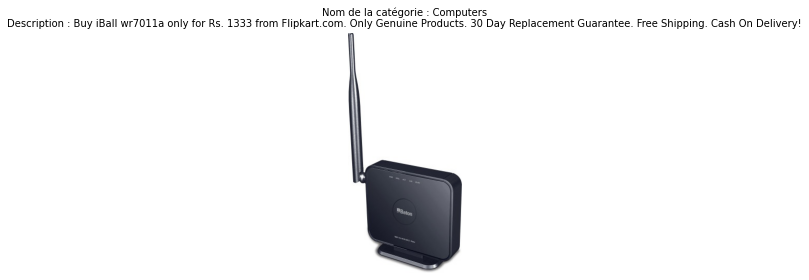

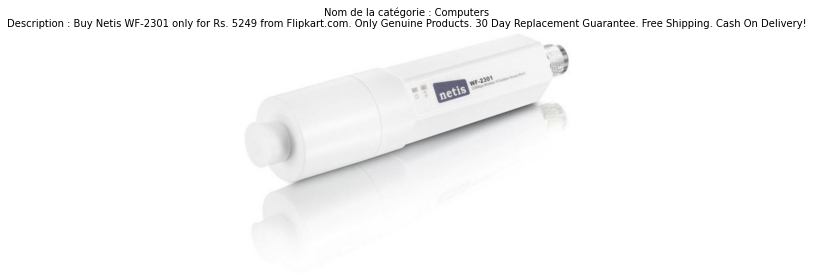

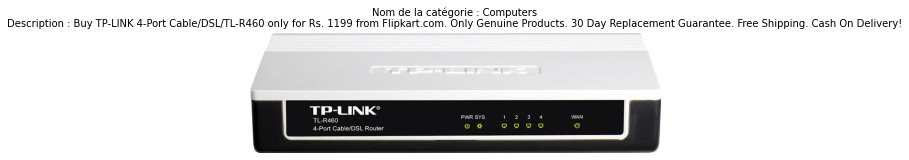

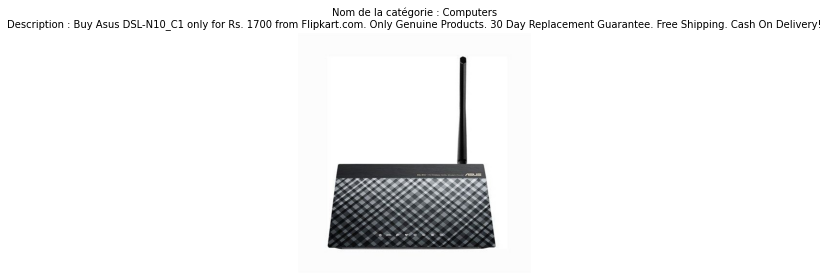

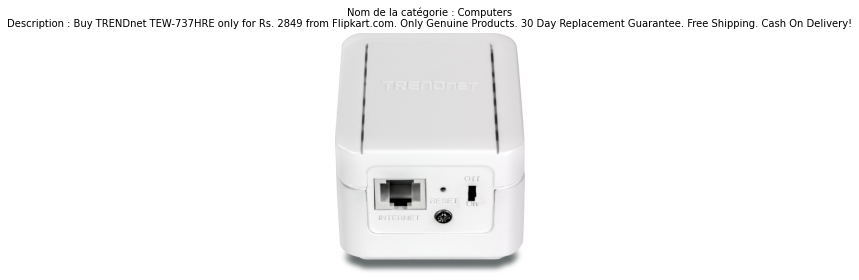

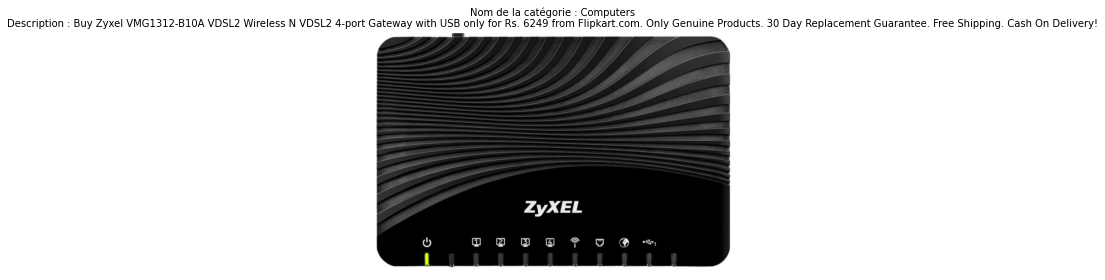

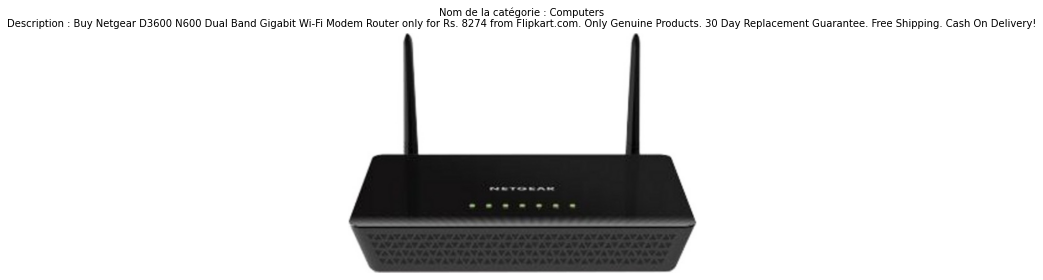

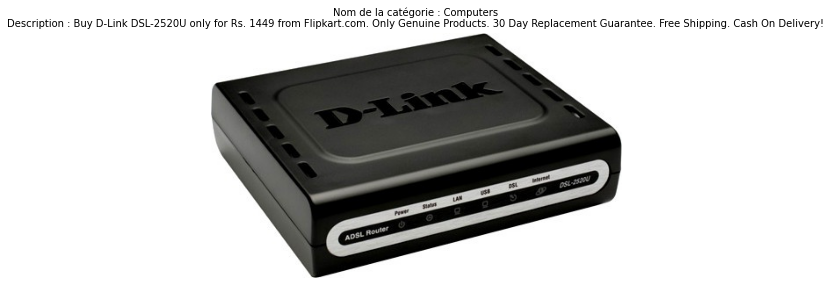

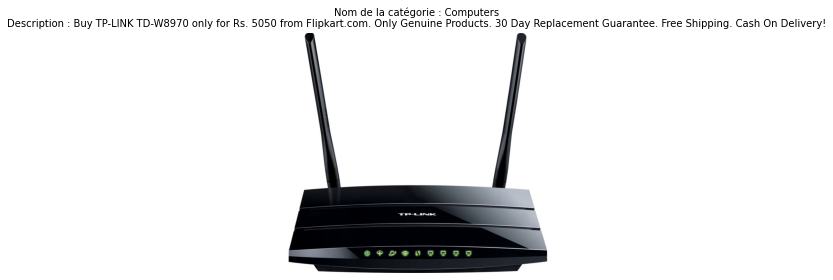

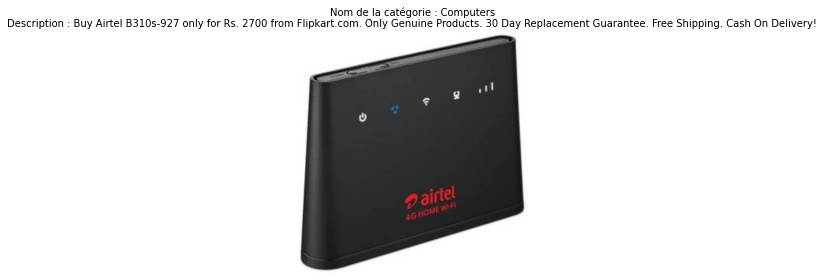

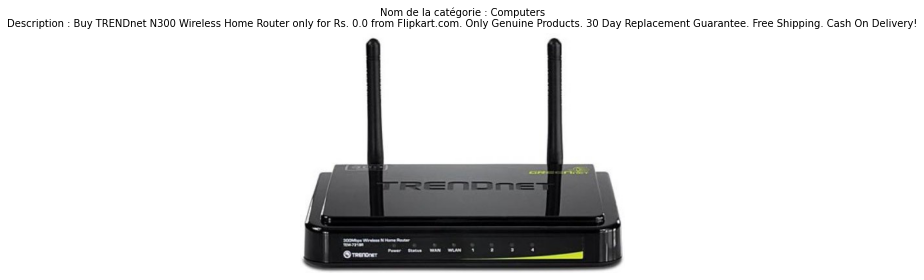

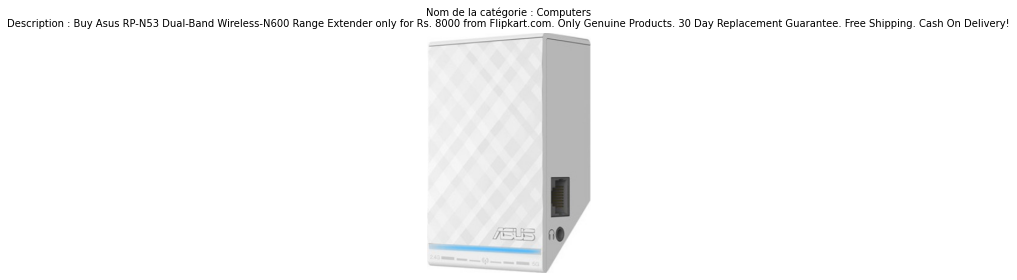

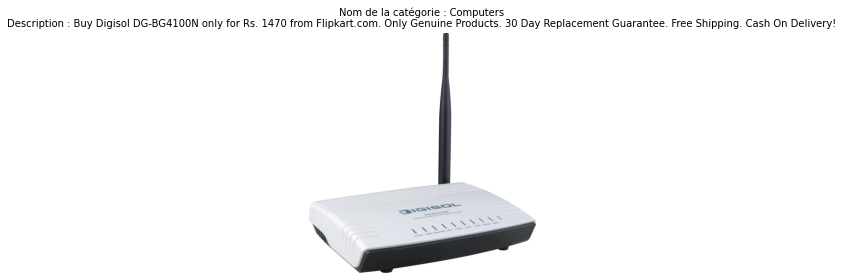

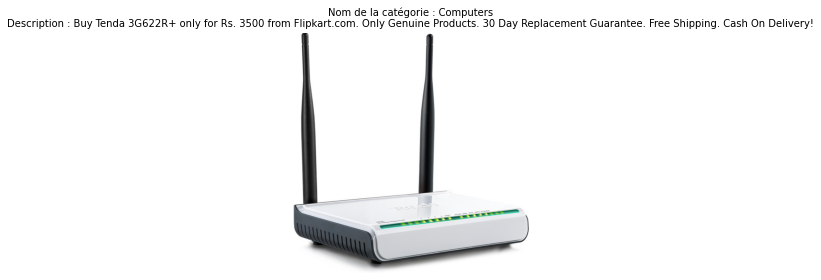

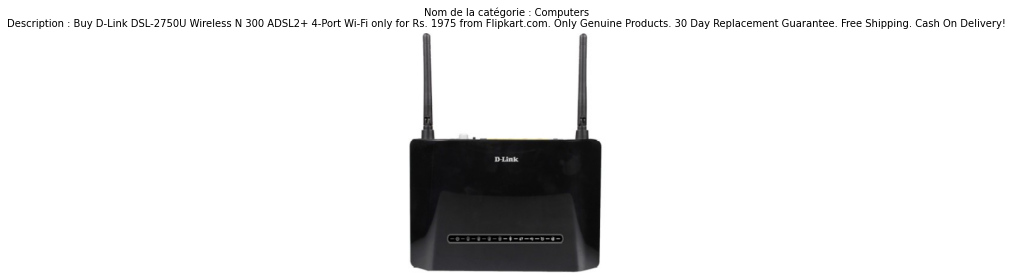

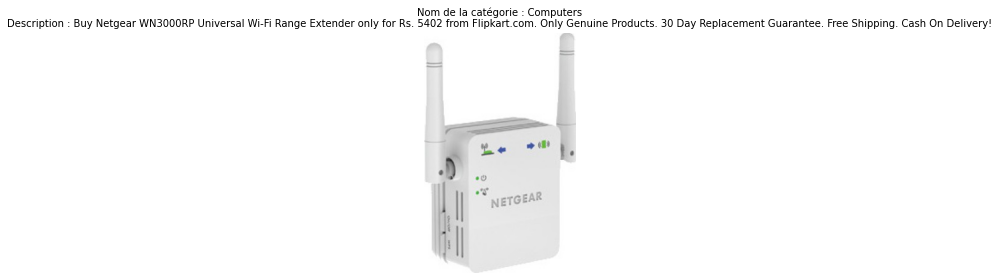

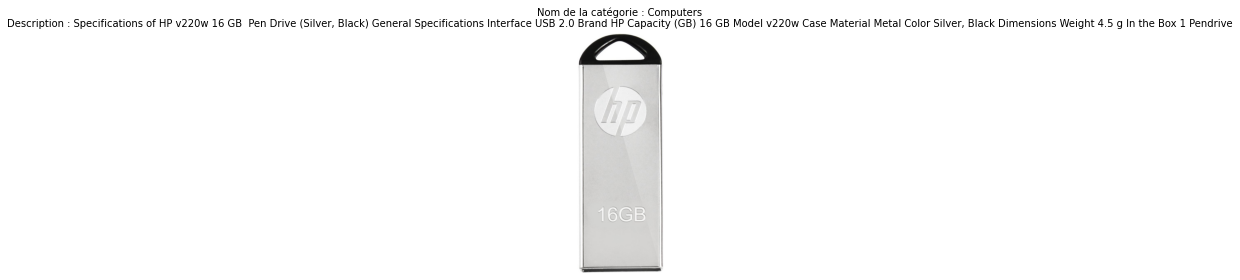

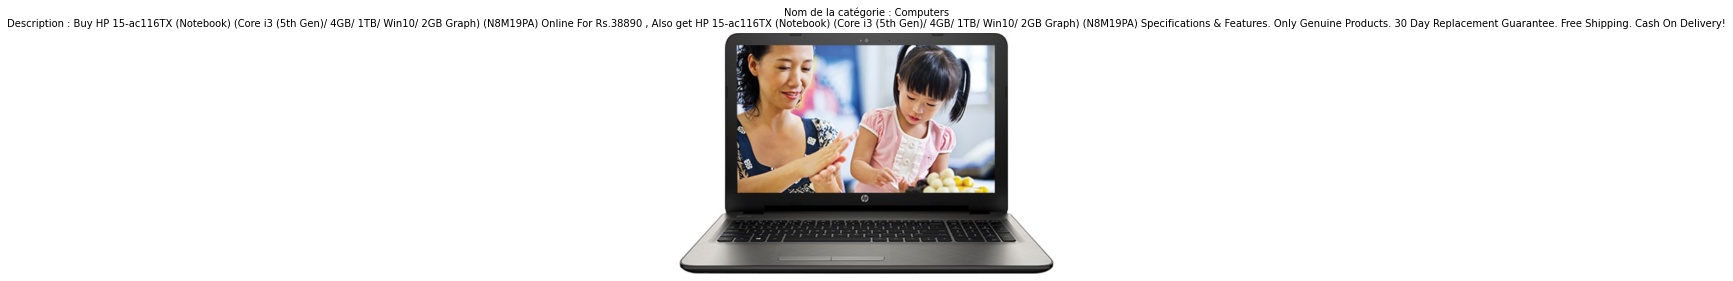

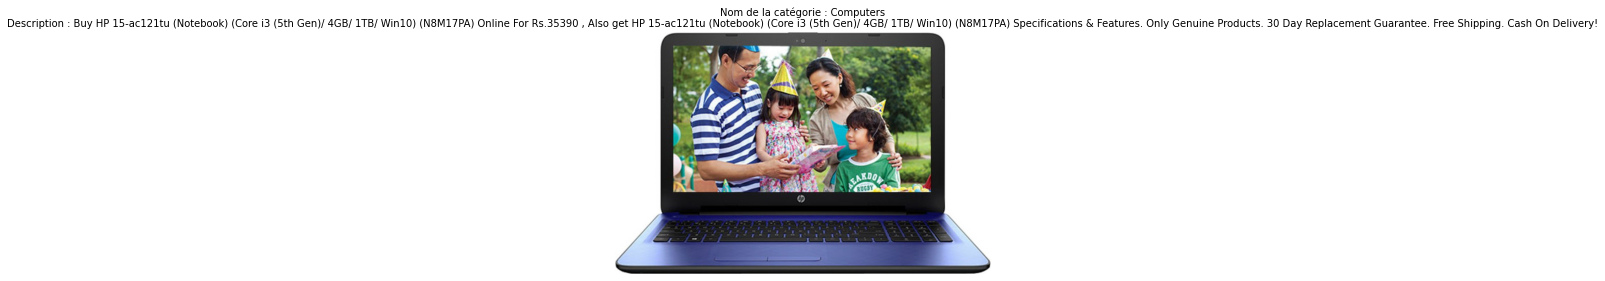

In [43]:
# Sélection des indices des images du cluster "Computers"
ids_a_afficher = [i for i in range(len(df["description"])) \
                if (df.iloc[i]['Cat_1']=='Computers') and (labels[i]!=5)]


print(ids_a_afficher)

# Définissez le chemin de votre répertoire d'images
path = 'Flipkart/Images'  # Mettez à jour avec le chemin correct vers votre répertoire d'images


# Créez une grille de sous-graphiques 4x1
plt.figure(figsize=(10, 10))  # Augmentez la taille de la figure

for i, row_id in enumerate(ids_a_afficher):
#     plt.subplot(4, 1, i + 1)
    filename = path + '/' + df['image'][row_id]  # Obtenez le nom de fichier de l'image depuis la colonne 'image'
    image = imread(filename)
    plt.imshow(image)
    plt.axis('off')
    
    # Augmentez la taille et la police du titre
    cat_1 = df['Cat_1'][row_id]
    description = df['description'][row_id]
    plt.title(f'Nom de la catégorie : {cat_1}\nDescription : {description}', fontsize=10)  # Ajustez la taille de la police selon vos préférences

    plt.tight_layout()
    plt.show()


<a id = 'sec:word2vec' ></a>
# IV. Word2Vec

Word2Vec est une technique avancée qui représente les mots sous forme de vecteurs numériques, capturant leurs significations et leurs relations en fonction de leur contexte d'utilisation. Contrairement aux méthodes plus simples, Word2Vec prend en compte le contexte sémantique, plaçant les mots similaires à proximité dans un espace multidimensionnel. Cela permet de révéler des relations subtiles entre les mots et trouve des applications dans des tâches telles que la similarité des mots, la classification de texte, et plus encore. 

In [44]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

__w2v_size__ (Taille du vecteur) : Définit la dimension des vecteurs de mots.

__w2v_window__ (Fenêtre contextuelle) : Contrôle la portée du contexte lors de la prédiction.

__w2v_min_count__ (Compte minimum) : Ignore les mots peu fréquents en dessous de ce seuil.

__w2v_epochs__ (Époques) : Le nombre d'itérations d'apprentissage sur les données.

Ces paramètres influent sur la qualité et la représentation des vecteurs de mots générés par le modèle Word2Vec, ce qui peut impacter sa capacité à capturer les relations sémantiques et syntaxiques entre les mots.

In [45]:
w2v_size=300
w2v_window=4
w2v_min_count=1
w2v_epochs=100
maxlen = 371 # adapt to length of sentences
sentences = df['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

En utilisant 'simple_preprocess', nous préparons les données d'entraînement pour le modèle Word2Vec en transformant chaque description en une liste de mots nettoyés et simplifiés. Ces listes de mots serviront de base pour créer des vecteurs de mots significatifs et représentatifs dans le modèle Word2Vec, ce qui nous permettra d'explorer les relations sémantiques et contextuelles entre les mots dans le contexte de notre ensemble de données de produits.

In [46]:
# Création et entraînement du modèle Word2Vec

print("Construction et entraînement du modèle Word2Vec ...")

# Création du modèle Word2Vec avec les paramètres spécifiés
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=1)

# Construction du vocabulaire à partir des phrases prétraitées
w2v_model.build_vocab(sentences)

# Entraînement du modèle Word2Vec sur les phrases prétraitées
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)

# Obtention des vecteurs de mots générés par le modèle
model_vectors = w2v_model.wv

# Obtention de la liste des mots du vocabulaire Word2Vec
w2v_words = model_vectors.index_to_key

# Affichage de la taille du vocabulaire
print("Taille du vocabulaire : %i" % len(w2v_words))
print("Word2Vec entraîné")

Construction et entraînement du modèle Word2Vec ...
Taille du vocabulaire : 4712
Word2Vec entraîné


total_examples : Définit le nombre total d'exemples dans le corpus d'entraînement, aidant le modèle à ajuster ses paramètres.

wv (Vecteurs de Mots) : Stocke les vecteurs numériques représentant les mots, capturant leurs relations sémantiques.

index_to_key : Fournit une liste des mots du vocabulaire, permettant l'accès aux mots associés aux vecteurs de mots.

In [47]:
# Préparation des phrases (tokenization)
print("Entraînement du tokenizer ...")

# Création d'un tokenizer pour convertir le texte en séquences numériques
tokenizer = Tokenizer()

# Ajustement du tokenizer aux phrases pour construire le vocabulaire
tokenizer.fit_on_texts(sentences)

# Conversion des phrases en séquences de valeurs numériques en utilisant le vocabulaire
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen=maxlen,
                            padding='post') 

# Calcul du nombre total de mots uniques dans le vocabulaire
num_words = len(tokenizer.word_index) + 1
print("Nombre de mots uniques : %i" % num_words)


Entraînement du tokenizer ...
Nombre de mots uniques : 4713


Ce segment de code prépare les données textuelles pour l'entraînement en les tokenizant, en les convertissant en séquences numériques et en garantissant des longueurs de séquence cohérentes. Il calcule également le nombre total de mots uniques dans le vocabulaire, ce qui est important pour construire la matrice d'embedding ultérieurement dans le modèle Word2Vec

In [48]:
# Création de la matrice d'embedding
print("Création de la matrice d'embedding ...")

# Taille de l'embedding Word2Vec
w2v_size = 300

# Récupération de l'index des mots du tokenizer
word_index = tokenizer.word_index

# Taille totale du vocabulaire
vocab_size = len(word_index) + 1

# Initialisation d'une matrice de zéros pour la représentation d'embedding
embedding_matrix = np.zeros((vocab_size, w2v_size))

# Compteurs pour suivre les mots trouvés dans le modèle Word2Vec
i = 0
j = 0

# Parcours des mots de l'index du tokenizer
for word, idx in word_index.items():
    i += 1
    # Vérification si le mot est présent dans le modèle Word2Vec
    if word in w2v_words:
        j += 1
        # Récupération de l'embedding vector pour le mot
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            # Mise à jour de la matrice d'embedding avec le vecteur correspondant
            embedding_matrix[idx] = model_vectors[word]
            
# Calcul du taux d'embedding des mots
word_rate = np.round(j / i, 4)

# Affichage du taux d'embedding des mots et de la forme de la matrice d'embedding
print("Taux d'embedding des mots : ", word_rate)
print("Matrice d'embedding : %s" % str(embedding_matrix.shape))


Création de la matrice d'embedding ...
Taux d'embedding des mots :  1.0
Matrice d'embedding : (4713, 300)


## Création du modèle d'embedding

In [49]:
# Création du modèle

# Définition de la forme de l'entrée du modèle
input = Input(shape=(len(x_sentences), maxlen), dtype='float64')

# Entrée pour les mots individuels
word_input = Input(shape=(maxlen,), dtype='float64')

# Couche d'embedding des mots
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=w2v_size,
                           weights=[embedding_matrix],
                           input_length=maxlen)(word_input)

# Couche de calcul de la moyenne globale des vecteurs d'embedding
word_vec = GlobalAveragePooling1D()(word_embedding)

# Création du modèle d'embedding des mots
embed_model = Model([word_input], word_vec)

# Affichage du résumé du modèle d'embedding
embed_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 371)]             0         
                                                                 
 embedding (Embedding)       (None, 371, 300)          1413900   
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 1413900 (5.39 MB)
Trainable params: 1413900 (5.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Exécution du modèle

In [50]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 3ms/step


(1050, 300)

In [51]:
ARI, X_tsne, labels = ARI_fct(embeddings)

Résultats des Métriques de Clustering:
ARI Score:       0.33
Silhouette Score: 0.5699999928474426
Homogénéité:     0.45
Complétude:      0.47
V-Measure:       0.46
Temps:           4.07 secondes


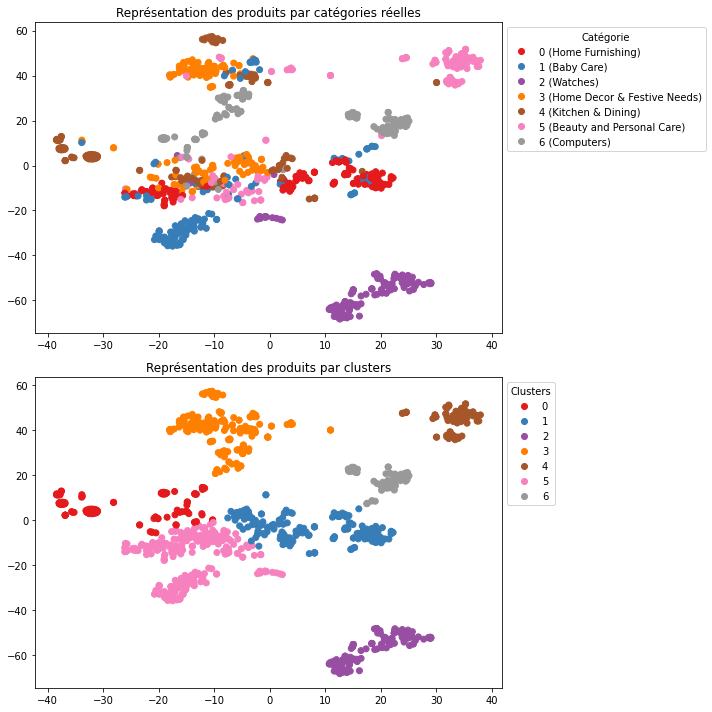

ARI: 0.33


In [52]:
TSNE_visu_fct(X_tsne, true_labels, labels, ARI)

In [53]:
# Transformation des étiquettes de cluster
cls_labels_transform = conf_mat_transform(true_labels, labels)

# Matrice de confusion après transformation
conf_mat = metrics.confusion_matrix(true_labels, cls_labels_transform)
print(conf_mat)

# Rapport de classification
print(metrics.classification_report(true_labels, cls_labels_transform))

Correspondance des clusters :  [4 0 2 3 5 1 6]
[[103  47   0   0   0   0   0]
 [ 24 103   0  14   3   0   6]
 [  1  14 134   0   1   0   0]
 [ 33  23   0  76  18   0   0]
 [ 21  22   0  48  57   2   0]
 [ 12  32   0  17   2  86   1]
 [  1   5   0  41  33   0  70]]
              precision    recall  f1-score   support

           0       0.53      0.69      0.60       150
           1       0.42      0.69      0.52       150
           2       1.00      0.89      0.94       150
           3       0.39      0.51      0.44       150
           4       0.50      0.38      0.43       150
           5       0.98      0.57      0.72       150
           6       0.91      0.47      0.62       150

    accuracy                           0.60      1050
   macro avg       0.67      0.60      0.61      1050
weighted avg       0.67      0.60      0.61      1050



<a id ='sec:bert'></a>
# V. BERT ( Bidirectional Encoder Representations from Transformers )

BERT (Bidirectional Encoder Representations from Transformers) est un modèle révolutionnaire de traitement du langage naturel (NLP) qui a transformé le paysage de l'analyse de texte. Contrairement aux modèles traditionnels qui traitent le texte de manière linéaire, BERT comprend le langage de manière bidirectionnelle, ce qui lui permet de capturer des nuances contextuelles complexes. Dans ce projet, nous explorons les capacités de BERT à travers deux approches distinctes. La première approche exploite la puissance du modèle 'bert-base-uncased' de la bibliothèque HuggingFace, un outil NLP populaire. La deuxième méthode utilise TensorFlow pour exploiter la profonde compréhension contextuelle de BERT. De plus, nous explorons le potentiel de BERT en utilisant un modèle pré-entraîné disponible à l'adresse 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'. À travers ces efforts, nous visons à affiner notre système de classification automatique des produits, améliorant à la fois sa précision et son efficacité. Cela nous permet de fournir des informations précieuses sur la catégorisation des biens de consommation pour notre projet, 'Classification Automatique des Biens de Consommation'.

In [54]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

/Users/ismailcanoguz/opt/anaconda3/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning:

Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.

/Users/ismailcanoguz/opt/anaconda3/lib/python3.8/site-packages/transformers/generation_tf_utils.py:24: FutureWarning:

Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.



In [55]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [56]:
max_length = 80
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['sentence_dl'].to_list()

loading configuration file config.json from cache at /Users/ismailcanoguz/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /Users/ismailcanoguz/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998e

In [57]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')


loading configuration file config.json from cache at /Users/ismailcanoguz/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/ismailcanoguz/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a4

1/1 [==============================] - 1s 1s/step
temps traitement :  123.0


In [58]:
ARI, X_tsne, labels = ARI_fct(features_bert)

Résultats des Métriques de Clustering:
ARI Score:       0.34
Silhouette Score: 0.5600000023841858
Homogénéité:     0.46
Complétude:      0.47
V-Measure:       0.47
Temps:           9.83 secondes


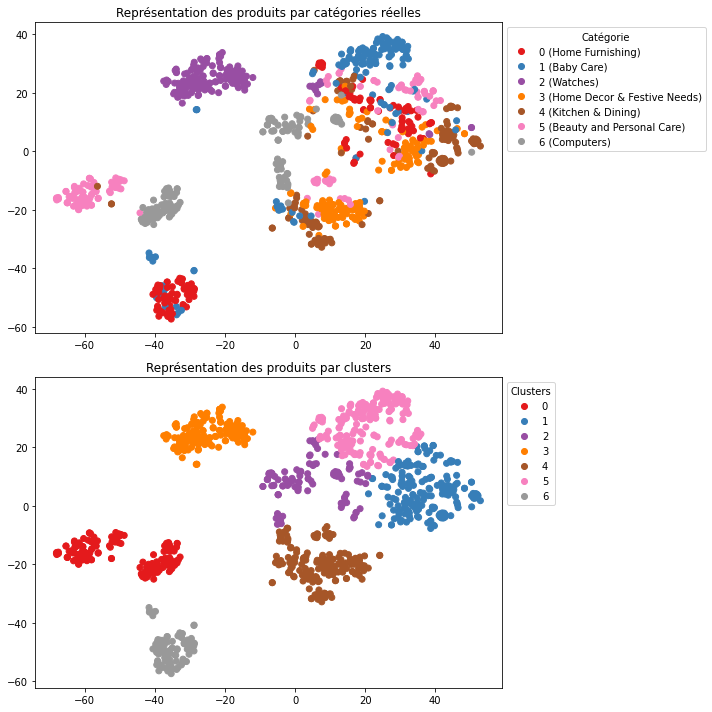

ARI: 0.34


In [59]:
TSNE_visu_fct(X_tsne, true_labels, labels, ARI)

In [60]:
# Transformation des étiquettes de cluster
cls_labels_transform = conf_mat_transform(true_labels, labels)

# Matrice de confusion après transformation
conf_mat = metrics.confusion_matrix(true_labels, cls_labels_transform)
print(conf_mat)

# Rapport de classification
print(metrics.classification_report(true_labels, cls_labels_transform))

Correspondance des clusters :  [5 4 6 2 3 1 0]
[[ 74  33   0   0  34   0   9]
 [ 22 101   3  14   9   0   1]
 [  0   4 136   0   4   0   6]
 [  0   5   0  77  52   0  16]
 [  0  12   0  52  76   3   7]
 [  0  25   0  21  22  80   2]
 [  0   1   0  15   1  68  65]]
              precision    recall  f1-score   support

           0       0.77      0.49      0.60       150
           1       0.56      0.67      0.61       150
           2       0.98      0.91      0.94       150
           3       0.43      0.51      0.47       150
           4       0.38      0.51      0.44       150
           5       0.53      0.53      0.53       150
           6       0.61      0.43      0.51       150

    accuracy                           0.58      1050
   macro avg       0.61      0.58      0.59      1050
weighted avg       0.61      0.58      0.59      1050



In [69]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [70]:
sentences = df['sentence_dl'].to_list()

In [71]:
max_length = 80
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

loading configuration file config.json from cache at /Users/ismailcanoguz/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/ismailcanoguz/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a4

temps traitement :  94.0


In [72]:
ARI, X_tsne, labels = ARI_fct(features_bert)

Résultats des Métriques de Clustering:
ARI Score:       0.34
Silhouette Score: 0.5699999928474426
Homogénéité:     0.45
Complétude:      0.46
V-Measure:       0.46
Temps:           3.44 secondes


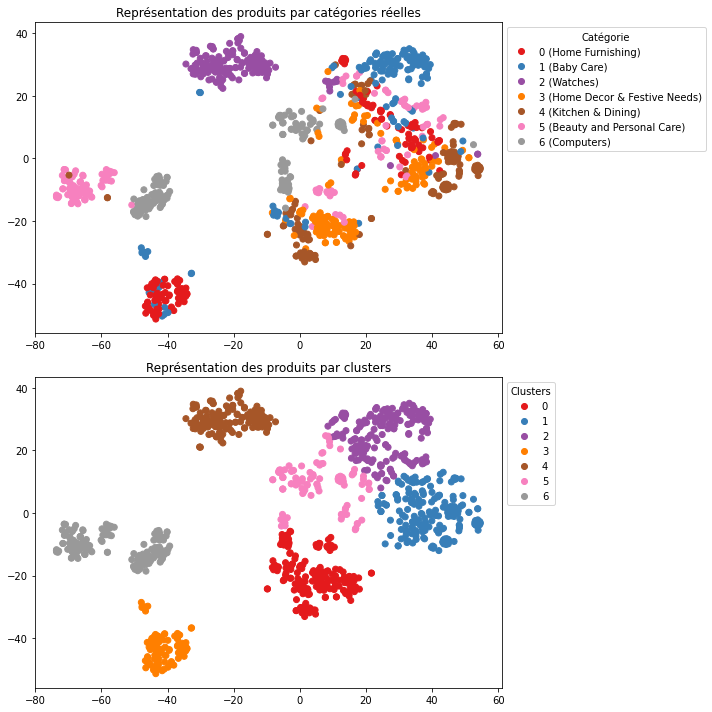

ARI: 0.34


In [73]:
TSNE_visu_fct(X_tsne, true_labels, labels, ARI)

<a id = 'sec:universal-sentence-encoder'></a>
# VI. Universal Sentence Encoder

Le USE est un modèle de traitement de langage qui convertit les phrases en vecteurs numériques denses, capturant leur signification et contexte. Il est utile pour classifier et regrouper des phrases, comme prédire des catégories de texte ("science", "littérature", etc.). Contrairement à BERT qui se focalise sur des tâches spécifiques, le USE vise à fournir une représentation générale de la signification des phrases, le rendant polyvalent pour diverses tâches de traitement du langage naturel.

In [61]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [62]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [63]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [64]:
batch_size = 10
sentences = df['sentence_dl'].to_list()

In [65]:
features_USE = feature_USE_fct(sentences, batch_size)

In [66]:
ARI, X_tsne, labels = ARI_fct(features_USE)


Résultats des Métriques de Clustering:
ARI Score:       0.44
Silhouette Score: 0.5199999809265137
Homogénéité:     0.56
Complétude:      0.57
V-Measure:       0.57
Temps:           7.11 secondes


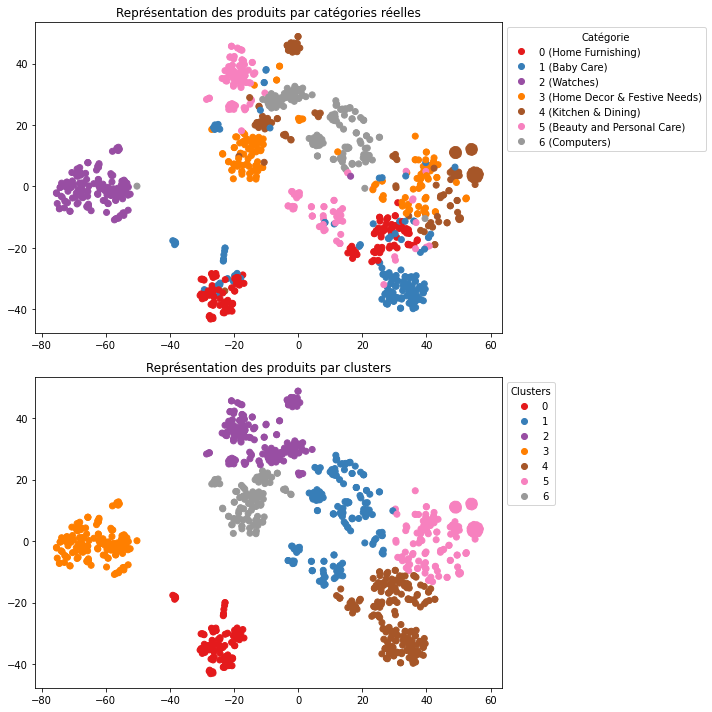

ARI: 0.44


In [67]:
TSNE_visu_fct(X_tsne, true_labels, labels, ARI)

In [68]:
# Transformation des étiquettes de cluster
cls_labels_transform = conf_mat_transform(true_labels, labels)

# Matrice de confusion après transformation
conf_mat = metrics.confusion_matrix(true_labels, cls_labels_transform)
print(conf_mat)

# Rapport de classification
print(metrics.classification_report(true_labels, cls_labels_transform))

Correspondance des clusters :  [0 6 5 2 1 4 3]
[[ 74  75   0   0   1   0   0]
 [ 25 103   0   9   3   5   5]
 [  0   0 149   0   0   0   1]
 [  0   0   0  71  58  10  11]
 [  1   4   0  25  91  22   7]
 [  0  12   0   1   4  84  49]
 [  0   0   1   0   1  51  97]]
              precision    recall  f1-score   support

           0       0.74      0.49      0.59       150
           1       0.53      0.69      0.60       150
           2       0.99      0.99      0.99       150
           3       0.67      0.47      0.55       150
           4       0.58      0.61      0.59       150
           5       0.49      0.56      0.52       150
           6       0.57      0.65      0.61       150

    accuracy                           0.64      1050
   macro avg       0.65      0.64      0.64      1050
weighted avg       0.65      0.64      0.64      1050



<a id='sec:conclusion'></a>
# VII. Conclusion

Dans cette étude, nous avons mené des expériences de classification de texte en utilisant diverses techniques d'encodage, notamment TF-IDF, Word2Vec, BERT et Universal Sentence Encoder (USE). Les résultats ont révélé des informations intéressantes sur les performances de ces méthodes.

TF-IDF, une approche traditionnelle basée sur la fréquence des termes, a étonnamment émergé comme la méthode la plus performante de cette étude. Il excelle dans la classification précise des données textuelles, ce qui suggère que, pour certaines tâches de classification de texte, la simplicité de TF-IDF et sa focalisation sur les statistiques des termes peuvent produire des résultats remarquables. C'est un excellent choix lorsque les ressources informatiques sont limitées ou lorsque la tâche ne nécessite pas de capturer des relations sémantiques complexes.

Word2Vec, qui exploite les plongements de mots pour représenter le texte, a montré un niveau d'exactitude respectable. Ses performances peuvent être attribuées à sa capacité à capturer des informations sémantiques, bien qu'il puisse ne pas saisir le contexte aussi complètement que BERT ou USE.

BERT et USE, deux modèles d'apprentissage en profondeur de pointe réputés pour leur compréhension contextuelle et leurs représentations sémantiques, n'ont étonnamment pas performé aussi bien que prévu dans cette étude. Plusieurs facteurs peuvent expliquer cette divergence. Tout d'abord, ces modèles exigent une quantité substantielle de données d'entraînement, et notre jeu de données pourrait ne pas avoir été assez grand pour qu'ils expriment pleinement leur potentiel. Deuxièmement, leurs performances peuvent bénéficier grandement d'un ajustement fin pour des tâches spécifiques, ce qui n'a pas été réalisé dans cette étude. Enfin, la complexité de ces modèles peut ne pas être nécessaire pour des tâches où des méthodes plus simples comme TF-IDF suffisent.

En conclusion, le choix de la technique d'encodage de texte doit être guidé par la tâche spécifique, la taille de l'ensemble de données et les ressources disponibles. Bien que BERT et USE soient des modèles puissants, leur performance supérieure n'est pas garantie dans tous les scénarios. La prééminence inattendue de TF-IDF souligne sa pertinence et son efficacité, en particulier pour les tâches simples de classification de texte et lorsque les ressources informatiques sont limitées. Pour maximiser les performances de BERT et USE, il peut être nécessaire de les ajuster finement sur des données spécifiques au domaine et sur des ensembles de données plus importants.